## Helpers and Imports

In [193]:
import pandas as pd
import numpy as np
import torch
from typing import Tuple, Dict, Any
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import torch
from model.model import MoEModel, Config, optimize

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

torch.manual_seed(np.random.randint(0, 10000))

save_path = "phase_change_results/"


In [194]:
import numpy as np

def superposition_measure(x_i: np.ndarray, X: np.ndarray) -> float:
    """Σ_j ( x̂_i · x_j )²  – ‘superposition score’ for one feature."""
    x_hat_i = x_i / np.linalg.norm(x_i)
    overlaps = X @ x_hat_i
    return float(np.sum(overlaps**2))


def color_from_xy(x: float, y: float, max_x: float = 1.0, max_y: float = 1.0) -> tuple[float, float, float]:
    """
    Reconstruct the paper’s legend → RGB.
      • x (horizontal)  = superposition score, clipped to ≤ 1
          0 ⇒ blue,  1 ⇒ red
      • y (vertical)    = ‖W_i‖,           clipped to ≤ 1
          0 ⇒ white, 1 ⇒ full-strength hue
    """
    # x = np.clip(x, 0, 1)
    # y = np.clip(y, 0, 1)
    max_x = max(max_x, 1)
    max_y = max(max_y, 1)

    base = np.array([x, 0.0, max_x - x])      # blue→red ramp
    return tuple(y * base + (max_y - y))        # mix with white


def rgb_to_hex(rgb: tuple[float, float, float]) -> str:
    return '#{:02x}{:02x}{:02x}'.format(
        *(int(round(255 * c)) for c in rgb)
    )


In [195]:
import pandas as pd

def compute_feature_metrics(W: np.ndarray) -> pd.DataFrame:
    """
    For every row of a weight-matrix **W** (shape = (n_features, d)) return:

      • norm         – ‖W_i‖
      • super_score  – Σ_j (x̂_i·x_j)²
      • x_coord      – clipped super_score  (what the paper puts on x-axis)
      • y_coord      – clipped norm         (what the paper puts on y-axis)
      • colour_hex   – HTML / matplotlib colour that matches the legend
    """
    if torch.is_tensor(W):
        W = W.detach().cpu().numpy()
    
    rows = []
    for i in range(W.shape[0]):
        norm_i = np.linalg.norm(W[i])
        sup_i  = superposition_measure(W[i], W)
        x_i    = sup_i # min(sup_i, 1.0)
        y_i    = norm_i # min(norm_i, 1.0)
        rows.append(
            (norm_i, sup_i, x_i, y_i, rgb_to_hex(color_from_xy(x_i, y_i)))
        )

    return pd.DataFrame(
        rows,
        columns=["norm", "super_score", "x_coord", "y_coord", "colour_hex"],
    )


In [196]:
dim_scalar = 1

def color_from_metrics(norm: float, superpos: float, max_norm: float, max_super: float) -> Tuple[float, float, float]:
    """
    Map (norm, superpos) to an RGB tuple with:
    - Top right (high norm, high super) -> Red
    - Top left (high norm, low super) -> Blue
    - Bottom (low norm) -> White
    
    Args:
        norm: L2 norm of the weights
        superpos: Superposition score
        max_norm: Maximum norm for normalization
        max_super: Maximum superposition score for normalization
    """

    # Normalize inputs to [0,1]
    y = np.clip(norm / max_norm, 0.0, dim_scalar)      # Vertical axis (norm)
    x = np.clip(superpos / max_super, 0.0, dim_scalar)  # Horizontal axis (superposition)
    
    # Create color components
    red = y * x           # Increases towards top-right
    blue = y * (dim_scalar - x)    # Increases towards top-left
    # All components approach 1 (white) as y approaches 0 (bottom)
    white_blend = dim_scalar - y
    
    # Blend with white
    r = red + white_blend
    g = white_blend
    b = blue + white_blend
    
    # Normalize to [0,1]
    return (
        min(dim_scalar, max(0.0, r)),
        min(dim_scalar, max(0.0, g)),
        min(dim_scalar, max(0.0, b))
    )

def plot_colormap_plotly(n: int = 200, *, max_norm: float = 1.0, max_super: float = 1.0):
    """
    Interactive Plotly visualization of the (norm, superposition) → color mapping.
    - x-axis: superposition (0 → 1)
    - y-axis: norm (0 → 1), origin at bottom (like origin='lower' in matplotlib)
    """
    # Build RGB image using your color_from_metrics(norm, superpos, max_norm, max_super)
    color_grid = np.zeros((n, n, 3), dtype=float)  # [rows (norm), cols (super)]
    norms = np.linspace(0.0, dim_scalar, n)
    supers = np.linspace(0.0, dim_scalar, n)
    for i, y in enumerate(norms):
        for j, x in enumerate(supers):
            color_grid[i, j] = color_from_metrics(
                norm=y, superpos=x, max_norm=max_norm, max_super=max_super
            )

    # Plotly expects 0-255 uint8 for go.Image
    img = (np.clip(color_grid, 0.0, 1) * 255).astype(np.uint8)

    # Each pixel spans dx, dy to map [0,1] on both axes
    dx = 1 / (n - 1) * dim_scalar
    dy = 1 / (n - 1) * dim_scalar

    fig = go.Figure(go.Image(z=img, x0=0.0, dx=dx, y0=0.0, dy=dy))
    # Make y increase upward (origin at bottom)
    fig.update_yaxes(range=[0, dim_scalar])
    fig.update_xaxes(range=[0, dim_scalar])

    fig.update_layout(
        width=800, height=600,
        title="Color Mapping Visualization (Plotly)",
        xaxis_title="Superposition Score",
        yaxis_title="L2 Norm (normalized)",
        margin=dict(l=60, r=20, t=60, b=60),
    )

    # Clean hover to show continuous coordinates
    fig.update_traces(
        hovertemplate="superposition=%{x:.3f}<br>norm=%{y:.3f}<extra></extra>"
    )

    # Annotations like the matplotlib version
    fig.add_annotation(x=0.10*dim_scalar, y=0.90*dim_scalar, text="Blue<br>(High norm,<br>Low super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.90*dim_scalar, y=0.90*dim_scalar, text="Red<br>(High norm,<br>High super)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="white")
    fig.add_annotation(x=0.50*dim_scalar, y=0.10*dim_scalar, text="White<br>(Low norm)", showarrow=False,
                       xanchor="center", yanchor="middle", font_color="black")

    return fig

# Usage:
fig = plot_colormap_plotly(n=200)
fig.show()


In [197]:
def analyze_norm_and_superposition_all_experts(grid_results, config, feature_index=-1, figsize=(15, 5), ):
    """
    Analyze norm and superposition for all experts in a given grid of results.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing sparsity_values and importance_values
        figsize: Figure size for the plots (default: (15, 5))
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    
    print(f"Analyzing {n_experts} experts for feature {feature_index}")
    
    # Store metrics for each grid cell and expert
    norm_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    superposition_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    color_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values), 3))

    # Analyze each expert
    for expert_id in range(n_experts):
        
        # Analyze each grid cell for this expert
        for i, sparsity in enumerate(sparsity_values):
            for j, importance in enumerate(importance_values):
                result = grid_results[(sparsity, importance)]
                
                # Get expert weights (shape: [1, 2, 1] -> [2, 1])
                expert_weights = result['expert_weights']  # First (and only) expert
                
                # Get weights for this expert
                expert_weight_matrix = expert_weights[expert_id]  # Shape: [n_features, n_hidden]
                
                expert_metrics = compute_feature_metrics(expert_weight_matrix).iloc[feature_index]
                
                norm_grids[expert_id, i, j] = expert_metrics['norm']
                superposition_grids[expert_id, i, j] = expert_metrics['super_score']

        # Analyze each grid cell for colors for this expert
        for i, sparsity in enumerate(sparsity_values):
            for j, importance in enumerate(importance_values):

                # Store RGB values for color visualization
                rgb_color = color_from_metrics(
                    norm_grids[expert_id, i, j], 
                    superposition_grids[expert_id, i, j],
                    max_norm=np.max(norm_grids[expert_id]),
                    max_super=np.max(superposition_grids[expert_id])
                )
                color_grids[expert_id, i, j] = rgb_color

    # Create visualization for each expert
    for expert_id in range(n_experts):
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle(f'Expert {expert_id} Analysis', fontsize=16)

        # Plot 1: Norms
        im1 = axes[0].imshow(norm_grids[expert_id], cmap='viridis', aspect='auto')
        axes[0].set_xlabel('Last Feature Importance')
        axes[0].set_ylabel('Feature Sparsity')
        axes[0].set_title('L2 Norms of Expert Weights')
        plt.colorbar(im1, ax=axes[0])

        # Plot 2: Superposition
        im2 = axes[1].imshow(superposition_grids[expert_id], cmap='viridis', aspect='auto')
        axes[1].set_xlabel('Last Feature Importance')
        axes[1].set_ylabel('Feature Sparsity')
        axes[1].set_title('Superposition Scores')
        plt.colorbar(im2, ax=axes[1])

        # Plot 3: Combined color visualization
        im3 = axes[2].imshow(color_grids[expert_id], aspect='auto')
        axes[2].set_xlabel('Last Feature Importance')
        axes[2].set_ylabel('Feature Sparsity')
        axes[2].set_title('Phase Change Diagram')

        # Set tick labels
        for ax in axes:
            x_step = max(1, len(importance_values) // 8)
            y_step = max(1, len(sparsity_values) // 6)
            
            x_ticks = range(0, len(importance_values), x_step)
            y_ticks = range(0, len(sparsity_values), y_step)
            
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

        plt.tight_layout()
        plt.show()
    
    return norm_grids, superposition_grids, color_grids, sparsity_values, importance_values

In [198]:
# def plot_norm_and_superposition_analysis(analysis_output, config, figsize=(15, 5)):
#     """
#     Plot the results from analyze_norm_and_superposition_all_experts.
    
#     Args:
#         analysis_output: Tuple returned by analyze_norm_and_superposition_all_experts
#                         (norm_grids, superposition_grids, color_grids, sparsity_values, importance_values)
#         config: Configuration object (for reference)
#         figsize: Figure size for the plots (default: (15, 5))
#     """
#     norm_grids, superposition_grids, color_grids, sparsity_values, importance_values = analysis_output
#     n_experts = norm_grids.shape[0]
    
#     print(f"Creating plots for {n_experts} experts")
    
#     # Create visualization for each expert
#     for expert_id in range(n_experts):
#         print(f"Creating plots for expert {expert_id}")
        
#         fig, axes = plt.subplots(1, 3, figsize=figsize)
#         fig.suptitle(f'Expert {expert_id} Analysis', fontsize=16)

#         # Plot 1: Norms
#         im1 = axes[0].imshow(norm_grids[expert_id], cmap='viridis', aspect='auto')
#         axes[0].set_xlabel('Last Feature Importance')
#         axes[0].set_ylabel('Feature Sparsity')
#         axes[0].set_title('L2 Norms of Expert Weights')
#         plt.colorbar(im1, ax=axes[0])

#         # Plot 2: Superposition
#         im2 = axes[1].imshow(superposition_grids[expert_id], cmap='viridis', aspect='auto')
#         axes[1].set_xlabel('Last Feature Importance')
#         axes[1].set_ylabel('Feature Sparsity')
#         axes[1].set_title('Superposition Scores')
#         plt.colorbar(im2, ax=axes[1])

#         # Plot 3: Combined color visualization
#         im3 = axes[2].imshow(color_grids[expert_id], aspect='auto')
#         axes[2].set_xlabel('Last Feature Importance')
#         axes[2].set_ylabel('Feature Sparsity')
#         axes[2].set_title('Norm + Superposition')

#         # Set tick labels
#         for ax in axes:
#             x_step = max(1, len(importance_values) // 8)
#             y_step = max(1, len(sparsity_values) // 6)
            
#             x_ticks = range(0, len(importance_values), x_step)
#             y_ticks = range(0, len(sparsity_values), y_step)
            
#             ax.set_xticks(x_ticks)
#             ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
#             ax.set_yticks(y_ticks)
#             ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])

#         plt.tight_layout()
#         plt.show()

# # # Now you can use it like this:
# # # First run the analysis:
# # analysis_output = analyze_norm_and_superposition_all_experts(grid_results_311_5, config)

# # # Then plot the results:
# # plot_norm_and_superposition_analysis(analysis_output, config)


In [199]:
import plotly.graph_objects as go

import numpy as np
import torch
import plotly.graph_objects as go

def _as_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def _pick_tickvals(vals, max_ticks):
    vals = _as_np(vals).astype(float)
    if len(vals) <= max_ticks:
        return vals, [f"{v:.2f}" for v in vals]
    idx = np.linspace(0, len(vals)-1, max_ticks).round().astype(int)
    picked = vals[idx]
    return picked, [f"{v:.2f}" for v in picked]

def _shape_or_fill_from_dict(grid_results, s_vals, i_vals, key_name='final_loss'):
    """Build z[i,j] from dict keyed by (sparsity, importance)."""
    z = np.full((len(s_vals), len(i_vals)), np.nan, float)
    # Make a fast lookup with tolerance for float keys
    keys = [k for k in grid_results.keys() if isinstance(k, tuple) and len(k) == 2]
    if not keys:
        return z
    s_keys = np.array([float(k[0]) for k in keys])
    i_keys = np.array([float(k[1]) for k in keys])
    for ii, s in enumerate(s_vals):
        s_idx = np.argmin(np.abs(s_keys - s))
        s_near = s_keys[s_idx]
        # collect all keys with this s_near (tolerant)
        mask_s = np.isclose(s_keys, s_near, rtol=0, atol=1e-9)
        i_keys_local = i_keys[mask_s]
        keys_local   = np.array(keys, dtype=object)[mask_s]
        for jj, imp in enumerate(i_vals):
            j_loc = np.argmin(np.abs(i_keys_local - imp))
            k = tuple(keys_local[j_loc])
            cell = grid_results[k]
            val = cell.get(key_name, cell.get('loss', np.nan))
            try:
                z[ii, jj] = float(val if not torch.is_tensor(val) else val.item())
            except Exception:
                z[ii, jj] = np.nan
    return z

def plot_loss_grid_sparsity_last_feature_plotly(grid_results: dict, config, n_experts: int = 1, max_loss: float = None):
    """
    Plotly heatmap of loss over (sparsity, last-feature-importance).
    Works with:
      - vectorized results: contains 'final_losses', 'sparsity_values', 'importance_values'
      - analyzed dict keyed by (sparsity, importance)
    """
    # axis values
    s_vals = _as_np(grid_results.get('sparsity_values', getattr(config, 'sparsity_values', []))).astype(float)
    i_vals = _as_np(grid_results.get('importance_values', getattr(config, 'importance_values', []))).astype(float)
    if s_vals.size == 0 or i_vals.size == 0:
        raise ValueError("Missing sparsity_values / importance_values")

    # z matrix
    losses = grid_results.get('final_losses', None)
    if losses is not None and len(losses) == len(s_vals)*len(i_vals):
        z = _as_np(losses).astype(float).reshape(len(s_vals), len(i_vals))
    else:
        z = _shape_or_fill_from_dict(grid_results, s_vals, i_vals, key_name='final_loss')

    if np.all(~np.isfinite(z)):
        raise ValueError("No finite losses found to plot")

    zmin = np.nanmin(z); zmax = np.nanmax(z) if max_loss is None else max_loss

    fig = go.Figure(go.Heatmap(
        z=z, x=i_vals, y=s_vals, colorscale='Viridis',
        zmin=zmin, zmax=zmax,
        colorbar=dict(title='Final Loss'),
        hovertemplate="importance=%{x:.3f}<br>sparsity=%{y:.3f}<br>loss=%{z:.6f}<extra></extra>"
    ))

    # ticks
    xt, xtxt = _pick_tickvals(i_vals, 3)
    yt, ytxt = _pick_tickvals(s_vals, 3)

    fig.update_layout(
        width=700, height=600, template='plotly_white',
        title="Final Training Loss Across Grid",
        xaxis=dict(title="Last Feature Importance", tickmode='array', tickvals=xt, ticktext=xtxt, tickangle=-45),
        yaxis=dict(title="Feature Sparsity", tickmode='array', tickvals=yt, ticktext=ytxt, autorange='reversed'),
        margin=dict(l=70, r=30, t=70, b=90)
    )
    fig.show()
    return fig

In [200]:
def save_grid_results(grid_results, config, filename=None, include_metadata=True):
    """
    Save grid results to a compressed numpy file (.npz) for later post-processing.
    
    Args:
        grid_results: Dictionary of results keyed by (sparsity, importance)
        config: Configuration object containing experiment parameters
        filename: Optional filename, defaults to timestamped name
        include_metadata: Whether to include config and metadata
    
    Returns:
        str: The filename that was saved
    """
    import os
    from datetime import datetime
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"grid_results_{timestamp}.npz"
    
    # Ensure .npz extension
    if not filename.endswith('.npz'):
        filename += '.npz'
    
    # Prepare data for saving
    save_data = {}
    
    # Extract grid parameters
    sparsity_values = getattr(config, 'sparsity_values', [])
    importance_values = getattr(config, 'importance_values', [])
    
    # Save grid parameters
    save_data['sparsity_values'] = np.array(sparsity_values)
    save_data['importance_values'] = np.array(importance_values)
    
    # Save configuration parameters
    if include_metadata:
        config_params = {
            'n_features': getattr(config, 'n_features', None),
            'n_hidden': getattr(config, 'n_hidden', None),
            'n_experts': getattr(config, 'n_experts', None),
            'n_active_experts': getattr(config, 'n_active_experts', None),
            'steps': getattr(config, 'steps', None),
            'n_models_per_cell': getattr(config, 'n_models_per_cell', None),
        }
        save_data['config_params'] = config_params
    
    # Process grid results - convert to structured arrays
    grid_keys = []
    final_losses = []
    expert_weights_list = []
    router_weights_list = []
    
    for (sparsity, importance), result in grid_results.items():
        grid_keys.append((float(sparsity), float(importance)))
        
        # Extract final loss
        final_loss = result.get('final_loss', result.get('loss', np.nan))
        if torch.is_tensor(final_loss):
            final_loss = final_loss.item()
        final_losses.append(final_loss)
        
        # Extract expert weights
        expert_weights = result.get('expert_weights', None)
        if expert_weights is not None:
            if torch.is_tensor(expert_weights):
                expert_weights = expert_weights.detach().cpu().numpy()
            expert_weights_list.append(expert_weights)
        else:
            expert_weights_list.append(None)
        
        # Extract router weights
        router_weights = result.get('router_weights', None)
        if router_weights is not None:
            if torch.is_tensor(router_weights):
                router_weights = router_weights.detach().cpu().numpy()
            router_weights_list.append(router_weights)
        else:
            router_weights_list.append(None)
    
    # Convert to arrays
    save_data['grid_keys'] = np.array(grid_keys)
    save_data['final_losses'] = np.array(final_losses)
    
    # Save expert weights as a list (since they may have different shapes)
    save_data['expert_weights_list'] = expert_weights_list
    save_data['router_weights_list'] = router_weights_list
    
    # Save additional metadata
    save_data['n_grid_points'] = len(grid_keys)
    save_data['save_timestamp'] = datetime.now().isoformat()
    
    # Save to file
    np.savez_compressed(filename, **save_data)
    
    print(f"Grid results saved to: {filename}")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_keys)} points")
    print(f"Data includes: grid parameters, losses, expert weights, router weights, config metadata")
    
    return filename


def load_grid_results(filename):
    """
    Load grid results from a saved .npz file.
    
    Args:
        filename: Path to the .npz file
        
    Returns:
        dict: Dictionary containing loaded data with keys:
            - 'grid_results': Reconstructed grid results dictionary
            - 'config_params': Configuration parameters
            - 'sparsity_values': Array of sparsity values
            - 'importance_values': Array of importance values
            - 'metadata': Additional metadata
    """
    if not filename.endswith('.npz'):
        filename += '.npz'
    
    # Load the data
    loaded_data = np.load(filename, allow_pickle=True)
    
    # Extract basic data
    sparsity_values = loaded_data['sparsity_values']
    importance_values = loaded_data['importance_values']
    grid_keys = loaded_data['grid_keys']
    final_losses = loaded_data['final_losses']
    expert_weights_list = loaded_data['expert_weights_list']
    router_weights_list = loaded_data['router_weights_list']
    
    # Reconstruct grid_results dictionary
    grid_results = {}
    for i, (sparsity, importance) in enumerate(grid_keys):
        result = {
            'final_loss': float(final_losses[i]),
            'loss': float(final_losses[i]),  # Keep both for compatibility
        }
        
        # Add expert weights if available
        if expert_weights_list[i] is not None:
            result['expert_weights'] = expert_weights_list[i]
        
        # Add router weights if available
        if router_weights_list[i] is not None:
            result['router_weights'] = router_weights_list[i]
        
        grid_results[(sparsity, importance)] = result
    
    # Prepare return data
    loaded_results = {
        'grid_results': grid_results,
        'sparsity_values': sparsity_values,
        'importance_values': importance_values,
        'final_losses': final_losses,
    }
    
    # Add config params if available
    if 'config_params' in loaded_data:
        loaded_results['config_params'] = loaded_data['config_params'].item()
    
    # Add metadata
    metadata = {
        'n_grid_points': int(loaded_data['n_grid_points']),
        'save_timestamp': str(loaded_data['save_timestamp']),
        'filename': filename
    }
    loaded_results['metadata'] = metadata
    
    print(f"Grid results loaded from: {filename}")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
    print(f"Data includes: grid parameters, losses, expert weights, router weights")
    
    return loaded_results

# # Save grid results
# save_grid_results(grid_results_100, config_100, "my_grid_results.npz")

# # Load saved experiment
# # Load the results
# loaded_data = load_grid_results("test_grid_results.npz")
# grid_results = loaded_data['grid_results']
# sparsity_values = loaded_data['sparsity_values']
# importance_values = loaded_data['importance_values']
# config_params = loaded_data.get('config_params', {})

# # Create a minimal config object with all required attributes
# class SimpleConfig:
#     def __init__(self, sparsity_values, importance_values, config_params):
#         self.sparsity_values = sparsity_values
#         self.importance_values = importance_values
#         self.n_experts = config_params.get('n_experts', 1)
#         self.n_features = config_params.get('n_features', 2)
#         self.n_hidden = config_params.get('n_hidden', 1)
#         self.n_active_experts = config_params.get('n_active_experts', 1)

# simple_config = SimpleConfig(sparsity_values, importance_values, config_params)

# # Run analysis directly
# analysis_output = analyze_norm_and_superposition_all_experts(grid_results, simple_config)
# plot_loss_grid_sparsity_last_feature_plotly(grid_results, simple_config, max_loss=.15)
# plot_norm_and_superposition_analysis(analysis_output, simple_config)

In [201]:
# def analyze_expert_activation_patterns(grid_results, config, expert_id=None, figsize=(15, 10), plot = False):
#     """
#     Analyze and plot the percentage of times a specific expert gets activated across the grid.
    
#     Args:
#         grid_results: Dictionary of results keyed by (sparsity, importance)
#         config: Configuration object
#         expert_id: Specific expert to analyze (None for all experts)
#         figsize: Figure size for the plots
#     """
#     sparsity_values = config.sparsity_values
#     importance_values = config.importance_values
#     n_experts = config.n_experts
    
#     if expert_id is not None:
#         print(f"Analyzing expert activation patterns for expert {expert_id}")
#         experts_to_analyze = [expert_id]
#     else:
#         print(f"Analyzing expert activation patterns for all {n_experts} experts")
#         experts_to_analyze = range(n_experts)
    
#     # Store activation percentages for each grid cell and expert
#     activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    
#     # Analyze each grid cell
#     for i, sparsity in enumerate(sparsity_values):
#         for j, importance in enumerate(importance_values):
#             result = grid_results[(sparsity, importance)]
            
#             # Get router weights (expert selection probabilities)
#             router_weights = result.get('router_weights', None)
#             if router_weights is not None:
#                 if torch.is_tensor(router_weights):
#                     router_weights = router_weights.detach().cpu().numpy()
                
#                 # Calculate activation percentages for each expert
#                 if len(router_weights.shape) == 2:
#                     # Average across features
#                     expert_activations = np.mean(router_weights, axis=1)
#                 else:
#                     expert_activations = router_weights
                
#                 # Store as percentages
#                 for expert_id in range(n_experts):
#                     activation_grids[expert_id, i, j] = expert_activations[expert_id] * 100
    
#     if plot:

#         # Create visualization
#         if expert_id is not None:
#             # Single expert analysis
#             fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#             fig.suptitle(f'Expert {expert_id} Activation Patterns', fontsize=16)
            
#             # Plot 1: Activation heatmap
#             im1 = axes[0].imshow(activation_grids[expert_id], cmap='viridis', aspect='auto')
#             axes[0].set_xlabel('Last Feature Importance')
#             axes[0].set_ylabel('Feature Sparsity')
#             axes[0].set_title(f'Expert {expert_id} Activation %')
#             plt.colorbar(im1, ax=axes[0])
            
#             # Plot 2: Activation distribution
#             axes[1].hist(activation_grids[expert_id].flatten(), bins=20, alpha=0.7, color='skyblue')
#             axes[1].set_xlabel('Activation Percentage')
#             axes[1].set_ylabel('Frequency')
#             axes[1].set_title(f'Expert {expert_id} Activation Distribution')
            
#             # Plot 3: Activation vs sparsity
#             sparsity_means = np.mean(activation_grids[expert_id], axis=1)
#             axes[2].plot(sparsity_values, sparsity_means, 'o-', linewidth=2, markersize=6)
#             axes[2].set_xlabel('Feature Sparsity')
#             axes[2].set_ylabel('Average Activation %')
#             axes[2].set_title(f'Expert {expert_id}: Activation vs Sparsity')
#             axes[2].grid(True, alpha=0.3)
            
#         else:
#             # All experts analysis
#             fig, axes = plt.subplots(2, 2, figsize=figsize)
#             fig.suptitle('Expert Activation Patterns Across Grid', fontsize=16)
            
#             # Plot 1: Average activation across all experts
#             avg_activation = np.mean(activation_grids, axis=0)
#             im1 = axes[0, 0].imshow(avg_activation, cmap='viridis', aspect='auto')
#             axes[0, 0].set_xlabel('Last Feature Importance')
#             axes[0, 0].set_ylabel('Feature Sparsity')
#             axes[0, 0].set_title('Average Expert Activation %')
#             plt.colorbar(im1, ax=axes[0, 0])
            
#             # Plot 2: Activation variance across experts
#             activation_variance = np.var(activation_grids, axis=0)
#             im2 = axes[0, 1].imshow(activation_variance, cmap='plasma', aspect='auto')
#             axes[0, 1].set_xlabel('Last Feature Importance')
#             axes[0, 1].set_ylabel('Feature Sparsity')
#             axes[0, 1].set_title('Expert Activation Variance %²')
#             plt.colorbar(im2, ax=axes[0, 1])
            
#             # Plot 3: Individual expert activations (first expert)
#             if n_experts > 0:
#                 im3 = axes[1, 0].imshow(activation_grids[0], cmap='viridis', aspect='auto')
#                 axes[1, 0].set_xlabel('Last Feature Importance')
#                 axes[1, 0].set_ylabel('Feature Sparsity')
#                 axes[1, 0].set_title(f'Expert 0 Activation %')
#                 plt.colorbar(im3, ax=axes[1, 0])
            
#             # Plot 4: Individual expert activations (second expert if exists)
#             if n_experts > 1:
#                 im4 = axes[1, 1].imshow(activation_grids[1], cmap='viridis', aspect='auto')
#                 axes[1, 1].set_xlabel('Last Feature Importance')
#                 axes[1, 1].set_ylabel('Feature Sparsity')
#                 axes[1, 1].set_title(f'Expert 1 Activation %')
#                 plt.colorbar(im4, ax=axes[1, 1])
#             else:
#                 # If only one expert, show activation distribution
#                 axes[1, 1].hist(activation_grids[0].flatten(), bins=20, alpha=0.7)
#                 axes[1, 1].set_xlabel('Activation Percentage')
#                 axes[1, 1].set_ylabel('Frequency')
#                 axes[1, 1].set_title('Expert 0 Activation Distribution')
        
#         # Set tick labels
#         if expert_id is not None:
#             axes_to_label = axes
#         else:
#             axes_to_label = axes.flat
        
#         for ax in axes_to_label:
#             x_step = max(1, len(importance_values) // 8)
#             y_step = max(1, len(sparsity_values) // 6)
            
#             x_ticks = range(0, len(importance_values), x_step)
#             y_ticks = range(0, len(sparsity_values), y_step)
            
#             ax.set_xticks(x_ticks)
#             ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
#             ax.set_yticks(y_ticks)
#             ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])
        
#         plt.tight_layout()
#         plt.show()
        
#         # Print summary statistics
#         if expert_id is not None:
#             expert_activations = activation_grids[expert_id]
#             print(f"\n=== Expert {expert_id} Activation Summary ===")
#             print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
#             print(f"Mean activation: {np.mean(expert_activations):.2f}% ± {np.std(expert_activations):.2f}%")
#             print(f"Min activation: {np.min(expert_activations):.2f}%")
#             print(f"Max activation: {np.max(expert_activations):.2f}%")
#         else:
#             print("\n=== Expert Activation Summary ===")
#             print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(grid_results)} points")
            
#             for expert_id in range(n_experts):
#                 expert_activations = activation_grids[expert_id]
#                 print(f"\nExpert {expert_id}:")
#                 print(f"  Mean activation: {np.mean(expert_activations):.2f}% ± {np.std(expert_activations):.2f}%")
#                 print(f"  Min activation: {np.min(expert_activations):.2f}%")
#                 print(f"  Max activation: {np.max(expert_activations):.2f}%")
        
#     return activation_grids, sparsity_values, importance_values


# def analyze_expert_activation_by_input_type(grid_results, config, expert_id=None, figsize=(15, 10)):
#     """
#     Analyze expert activation patterns specifically for different input types:
#     1. Non-zero inputs (active features)
#     2. Regular inputs (with feature sparsity)
    
#     Args:
#         grid_results: Dictionary of results keyed by (sparsity, importance)
#         config: Configuration object
#         expert_id: Specific expert to analyze (None for all experts)
#         figsize: Figure size for the plots
#     """
#     sparsity_values = config.sparsity_values
#     importance_values = config.importance_values
#     n_experts = config.n_experts
    
#     if expert_id is not None:
#         print(f"Analyzing expert {expert_id} activation by input type")
#         experts_to_analyze = [expert_id]
#     else:
#         print(f"Analyzing expert activation by input type for all {n_experts} experts")
#         experts_to_analyze = range(n_experts)
    
#     # Store activation patterns for different input types
#     non_zero_activations = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
#     regular_activations = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    
#     # Analyze each grid cell
#     for i, sparsity in enumerate(sparsity_values):
#         for j, importance in enumerate(importance_values):
#             result = grid_results[(sparsity, importance)]
            
#             # Get router weights
#             router_weights = result.get('router_weights', None)
#             if router_weights is not None:
#                 if torch.is_tensor(router_weights):
#                     router_weights = router_weights.detach().cpu().numpy()
                
#                 # Calculate activations for different input scenarios
#                 if len(router_weights.shape) == 2:
#                     # For feature-wise routing
#                     for expert_id in range(n_experts):
#                         # Non-zero inputs: average activation across all features
#                         non_zero_activations[expert_id, i, j] = np.mean(router_weights[expert_id]) * 100
                        
#                         # Regular inputs: consider sparsity effect
#                         sparsity_factor = 1.0 - sparsity  # Inverse of sparsity
#                         regular_activations[expert_id, i, j] = np.mean(router_weights[expert_id]) * sparsity_factor * 100
#                 else:
#                     # For global routing
#                     for expert_id in range(n_experts):
#                         non_zero_activations[expert_id, i, j] = router_weights[expert_id] * 100
#                         regular_activations[expert_id, i, j] = router_weights[expert_id] * 100
    
#     # Create visualization
#     if expert_id is not None:
#         # Single expert analysis
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#         fig.suptitle(f'Expert {expert_id} Activation by Input Type', fontsize=16)
        
#         # Plot 1: Non-zero input activations
#         im1 = axes[0].imshow(non_zero_activations[expert_id], cmap='viridis', aspect='auto')
#         axes[0].set_xlabel('Last Feature Importance')
#         axes[0].set_ylabel('Feature Sparsity')
#         axes[0].set_title(f'Expert {expert_id}: Non-zero Input Activation %')
#         plt.colorbar(im1, ax=axes[0])
        
#         # Plot 2: Regular input activations
#         im2 = axes[1].imshow(regular_activations[expert_id], cmap='viridis', aspect='auto')
#         axes[1].set_xlabel('Last Feature Importance')
#         axes[1].set_ylabel('Feature Sparsity')
#         axes[1].set_title(f'Expert {expert_id}: Regular Input Activation %')
#         plt.colorbar(im2, ax=axes[1])
        
#         # Plot 3: Difference
#         diff = non_zero_activations[expert_id] - regular_activations[expert_id]
#         im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto')
#         axes[2].set_xlabel('Last Feature Importance')
#         axes[2].set_ylabel('Feature Sparsity')
#         axes[2].set_title(f'Expert {expert_id}: Non-zero - Regular (Red=Higher Non-zero)')
#         plt.colorbar(im3, ax=axes[2])
        
#     else:
#         # All experts analysis
#         fig, axes = plt.subplots(2, 2, figsize=figsize)
#         fig.suptitle('Expert Activation by Input Type', fontsize=16)
        
#         # Plot 1: Non-zero input activations (first expert)
#         if n_experts > 0:
#             im1 = axes[0, 0].imshow(non_zero_activations[0], cmap='viridis', aspect='auto')
#             axes[0, 0].set_xlabel('Last Feature Importance')
#             axes[0, 0].set_ylabel('Feature Sparsity')
#             axes[0, 0].set_title('Expert 0: Non-zero Input Activation %')
#             plt.colorbar(im1, ax=axes[0, 0])
        
#         # Plot 2: Regular input activations (first expert)
#         if n_experts > 0:
#             im2 = axes[0, 1].imshow(regular_activations[0], cmap='viridis', aspect='auto')
#             axes[0, 1].set_xlabel('Last Feature Importance')
#             axes[0, 1].set_ylabel('Feature Sparsity')
#             axes[0, 1].set_title('Expert 0: Regular Input Activation %')
#             plt.colorbar(im2, ax=axes[0, 1])
        
#         # Plot 3: Non-zero vs Regular comparison (first expert)
#         if n_experts > 0:
#             diff = non_zero_activations[0] - regular_activations[0]
#             im3 = axes[1, 0].imshow(diff, cmap='RdBu_r', aspect='auto')
#             axes[1, 0].set_xlabel('Last Feature Importance')
#             axes[1, 0].set_ylabel('Feature Sparsity')
#             axes[1, 0].set_title('Expert 0: Non-zero - Regular (Red=Higher Non-zero)')
#             plt.colorbar(im3, ax=axes[1, 0])
        
#         # Plot 4: Activation difference across experts
#         if n_experts > 1:
#             expert_diff = np.mean(non_zero_activations - regular_activations, axis=(1, 2))
#             axes[1, 1].bar(range(n_experts), expert_diff, alpha=0.7)
#             axes[1, 1].set_xlabel('Expert ID')
#             axes[1, 1].set_ylabel('Avg Non-zero - Regular Activation %')
#             axes[1, 1].set_title('Expert Activation Difference')
#             axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
#         else:
#             # If only one expert, show activation distribution
#             axes[1, 1].hist(non_zero_activations[0].flatten(), bins=20, alpha=0.7, label='Non-zero')
#             axes[1, 1].hist(regular_activations[0].flatten(), bins=20, alpha=0.7, label='Regular')
#             axes[1, 1].set_xlabel('Activation Percentage')
#             axes[1, 1].set_ylabel('Frequency')
#             axes[1, 1].set_title('Expert 0 Activation Distribution')
#             axes[1, 1].legend()
    
#     # Set tick labels
#     if expert_id is not None:
#         axes_to_label = axes
#     else:
#         axes_to_label = axes.flat
    
#     for ax in axes_to_label:
#         x_step = max(1, len(importance_values) // 8)
#         y_step = max(1, len(sparsity_values) // 6)
        
#         x_ticks = range(0, len(importance_values), x_step)
#         y_ticks = range(0, len(sparsity_values), y_step)
        
#         ax.set_xticks(x_ticks)
#         ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
#         ax.set_yticks(y_ticks)
#         ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics
#     if expert_id is not None:
#         non_zero_avg = np.mean(non_zero_activations[expert_id])
#         regular_avg = np.mean(regular_activations[expert_id])
#         diff_avg = non_zero_avg - regular_avg
        
#         print(f"\n=== Expert {expert_id} Activation by Input Type Summary ===")
#         print(f"Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activations[expert_id]):.2f}%")
#         print(f"Regular input activation: {regular_avg:.2f}% ± {np.std(regular_activations[expert_id]):.2f}%")
#         print(f"Difference (Non-zero - Regular): {diff_avg:.2f}%")
#     else:
#         print("\n=== Expert Activation by Input Type Summary ===")
#         for expert_id in range(n_experts):
#             non_zero_avg = np.mean(non_zero_activations[expert_id])
#             regular_avg = np.mean(regular_activations[expert_id])
#             diff_avg = non_zero_avg - regular_avg
            
#             print(f"\nExpert {expert_id}:")
#             print(f"  Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activations[expert_id]):.2f}%")
#             print(f"  Regular input activation: {regular_avg:.2f}% ± {np.std(regular_activations[expert_id]):.2f}%")
#             print(f"  Difference (Non-zero - Regular): {diff_avg:.2f}%")
    
#     return non_zero_activations, regular_activations, sparsity_values, importance_values


# def analyze_all_experts_activation(grid_results, config, analysis_type='both'):
#     """
#     Wrapper function to analyze activation patterns for all experts.
    
#     Args:
#         grid_results: Dictionary of results keyed by (sparsity, importance)
#         config: Configuration object
#         analysis_type: 'patterns', 'input_type', or 'both'
#     """
#     n_experts = config.n_experts
#     print(f"=== Analyzing activation patterns for all {n_experts} experts ===")
    
#     # if analysis_type in ['patterns', 'both']:
#     #     print("\n--- Basic Activation Patterns ---")
#     #     for expert_id in range(n_experts):
#     #         print(f"\nAnalyzing expert {expert_id}...")
#     #         analyze_expert_activation_patterns(grid_results, config, expert_id=expert_id)
    
#     if analysis_type in ['input_type', 'both']:
#         print("\n--- Input Type Analysis ---")
#         for expert_id in range(n_experts):
#             analyze_expert_activation_by_input_type(grid_results, config, expert_id=expert_id)
    
#     print(f"\n=== Completed analysis for all {n_experts} experts ===")


# # Usage examples:

# # Analyze a specific expert
# # analyze_expert_activation_patterns(grid_results, config, expert_id=0)
# # analyze_expert_activation_by_input_type(grid_results, config, expert_id=1)

# # Analyze all experts with one function call
# # analyze_all_experts_activation(grid_results, config, analysis_type='both')

# # Or analyze specific types for all experts
# # analyze_all_experts_activation(grid_results, config, analysis_type='patterns')
# # analyze_all_experts_activation(grid_results, config, analysis_type='input_type')

## Expert Allocation Simulations

In [202]:
# def simulate_expert_activation(grid_results, config, n_samples=5000, expert_id=None):
#     """
#     Simulate expert activation by sampling from input distributions and running router inference.
#     """
#     sparsity_values = config.sparsity_values
#     importance_values = config.importance_values
#     n_experts = config.n_experts
#     n_features = config.n_features
    
#     print(f"Simulating expert activation with {n_samples} samples for {n_experts} experts")
#     print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(sparsity_values) * len(importance_values)} cells")
    
#     # Store simulation results
#     simulation_results = {}
    
#     for i, sparsity in enumerate(sparsity_values):
#         for j, importance in enumerate(importance_values):
#             result = grid_results[(sparsity, importance)]
            
#             # Get router weights and expert weights using the correct keys
#             router_weights = result.get('gate_params', None)
#             expert_weights = result.get('expert_weights', None)
            
#             if router_weights is None or expert_weights is None:
#                 print(f"Warning: Missing data for cell ({sparsity:.3f}, {importance:.3f})")
#                 print(f"  Available keys: {list(result.keys())}")
#                 continue
                
#             if torch.is_tensor(router_weights):
#                 router_weights = router_weights.detach().cpu().numpy()
#             if torch.is_tensor(expert_weights):
#                 expert_weights = expert_weights.detach().cpu().numpy()
            
#             # print(f"Processing cell ({sparsity:.3f}, {importance:.3f}): router shape {router_weights.shape}, expert shape {expert_weights.shape}")
            
#             # Simulate input sampling and expert selection
#             cell_results = simulate_cell_expert_selection(
#                 router_weights, expert_weights, sparsity, importance, 
#                 n_features, n_experts, n_samples
#             )
            
#             simulation_results[(sparsity, importance)] = cell_results
    
#     print(f"Completed simulation for {len(simulation_results)} grid cells")
#     return simulation_results


# def simulate_cell_expert_selection(router_weights, expert_weights, sparsity, importance, 
#                                   n_features, n_experts, n_samples):
#     """
#     Simulate expert selection for a single grid cell.
#     """
#     # Initialize counters
#     expert_activations = {i: 0 for i in range(n_experts)}
#     non_zero_expert_activations = {i: 0 for i in range(n_experts)}
    
#     # Debug info
#     # print(f"  Cell simulation: sparsity={sparsity:.3f}, importance={importance:.3f}")
#     # print(f"  Router weights shape: {router_weights.shape}")
#     # print(f"  Expert weights shape: {expert_weights.shape}")
    
#     # Simulate n_samples input vectors
#     for sample_idx in range(n_samples):
#         # Generate input vector based on sparsity and importance
#         input_vector = generate_input_sample(sparsity, importance, n_features)
        
#         # Count non-zero inputs
#         non_zero_count = np.count_nonzero(input_vector)
        
#         # Simulate router selection
#         selected_expert = simulate_router_selection(router_weights, input_vector, n_experts)
        
#         # Count activations
#         expert_activations[selected_expert] += 1
        
#         # Count activations for non-zero inputs only
#         if non_zero_count > 0:
#             non_zero_expert_activations[selected_expert] += 1
        
#         # Debug first few samples
#         # if sample_idx < 3:
#         #     print(f"    Sample {sample_idx}: input={input_vector[:3]}..., non_zero={non_zero_count}, expert={selected_expert}")
    
#     # Calculate percentages
#     total_samples = n_samples
#     non_zero_samples = sum(1 for i in range(n_samples) 
#                           if np.count_nonzero(generate_input_sample(sparsity, importance, n_features)) > 0)
    
#     # Debug activation counts
#     # print(f"  Activation counts: {expert_activations}")
#     # print(f"  Non-zero activation counts: {non_zero_expert_activations}")
#     # print(f"  Total samples: {total_samples}, Non-zero samples: {non_zero_samples}")
    
#     results = {
#         'total_activations': {k: v/total_samples*100 for k, v in expert_activations.items()},
#         'non_zero_activations': {k: v/non_zero_samples*100 if non_zero_samples > 0 else 0 
#                                 for k, v in non_zero_expert_activations.items()},
#         'total_samples': total_samples,
#         'non_zero_samples': non_zero_samples,
#         'sparsity': sparsity,
#         'importance': importance
#     }
    
#     return results


# def generate_input_sample(sparsity, importance, n_features):
#     """
#     Generate a single input sample based on sparsity and importance parameters.
#     """
#     # Create feature importance weights (decreasing from first to last feature)
#     feature_weights = np.array([importance**i for i in range(n_features)])
    
#     # Sample which features are active based on sparsity
#     active_features = np.random.random(n_features) > sparsity
    
#     # Generate input values for active features
#     input_vector = np.zeros(n_features)
#     for i in range(n_features):
#         if active_features[i]:
#             # Sample from a distribution weighted by feature importance
#             # Higher importance features get higher values
#             input_vector[i] = np.random.exponential(feature_weights[i])
    
#     return input_vector


# def simulate_router_selection(router_weights, input_vector, n_experts):
#     """
#     Simulate router selection based on input vector and router weights.
#     """
#     if len(router_weights.shape) == 2:
#         # Feature-wise routing: compute expert scores for each feature
#         expert_scores = np.zeros(n_experts)
        
#         for feature_idx in range(len(input_vector)):
#             if input_vector[feature_idx] > 0:  # Only active features contribute
#                 feature_importance = input_vector[feature_idx]
#                 for expert_idx in range(n_experts):
#                     expert_scores[expert_idx] += router_weights[expert_idx, feature_idx] * feature_importance
        
#         # Select expert with highest score
#         selected_expert = np.argmax(expert_scores)
#     else:
#         # Global routing: use router weights directly
#         # Add some noise to break ties
#         scores = router_weights + np.random.normal(0, 0.01, size=router_weights.shape)
#         selected_expert = np.argmax(scores)
    
#     return selected_expert


# def analyze_simulation_results(simulation_results, config, expert_id=None, figsize=(15, 10)):
#     """
#     Analyze and plot the simulation results.
#     """
#     sparsity_values = config.sparsity_values
#     importance_values = config.importance_values
#     n_experts = config.n_experts
    
#     if expert_id is not None:
#         print(f"Analyzing simulation results for expert {expert_id}")
#         experts_to_analyze = [expert_id]
#     else:
#         print(f"Analyzing simulation results for all {n_experts} experts")
#         experts_to_analyze = range(n_experts)
    
#     # Extract data for plotting
#     total_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
#     non_zero_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    
#     for i, sparsity in enumerate(sparsity_values):
#         for j, importance in enumerate(importance_values):
#             if (sparsity, importance) in simulation_results:
#                 cell_result = simulation_results[(sparsity, importance)]
                
#                 for expert_idx in range(n_experts):
#                     total_activation_grids[expert_idx, i, j] = cell_result['total_activations'][expert_idx]
#                     non_zero_activation_grids[expert_idx, i, j] = cell_result['non_zero_activations'][expert_idx]
    
#     # Create visualization
#     if expert_id is not None:
#         # Single expert analysis
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#         fig.suptitle(f'Expert {expert_id} Activation Simulation Results', fontsize=16)
        
#         # Plot 1: Total activation
#         im1 = axes[0].imshow(total_activation_grids[expert_id], cmap='viridis', aspect='auto')
#         axes[0].set_xlabel('Last Feature Importance')
#         axes[0].set_ylabel('Feature Sparsity')
#         axes[0].set_title(f'Expert {expert_id}: Total Activation %')
#         plt.colorbar(im1, ax=axes[0])
        
#         # Plot 2: Non-zero activation
#         im2 = axes[1].imshow(non_zero_activation_grids[expert_id], cmap='viridis', aspect='auto')
#         axes[1].set_xlabel('Last Feature Importance')
#         axes[1].set_ylabel('Feature Sparsity')
#         axes[1].set_title(f'Expert {expert_id}: Non-zero Input Activation %')
#         plt.colorbar(im2, ax=axes[1])
        
#         # Plot 3: Difference
#         diff = non_zero_activation_grids[expert_id] - total_activation_grids[expert_id]
#         max_abs_diff = max(abs(np.min(diff)), abs(np.max(diff)))
#         im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
#                              vmin=-max_abs_diff, vmax=max_abs_diff)
#         axes[2].set_xlabel('Last Feature Importance')
#         axes[2].set_ylabel('Feature Sparsity')
#         axes[2].set_title(f'Expert {expert_id}: Non-zero - Total (Red=Higher Non-zero)')
#         plt.colorbar(im3, ax=axes[2])
        
#     else:
#         # All experts analysis
#         fig, axes = plt.subplots(2, 2, figsize=figsize)
#         fig.suptitle('Expert Activation Simulation Results', fontsize=16)
        
#         # Plot 1: Average total activation across all experts
#         avg_total = np.mean(total_activation_grids, axis=0)
#         im1 = axes[0, 0].imshow(avg_total, cmap='viridis', aspect='auto')
#         axes[0, 0].set_xlabel('Last Feature Importance')
#         axes[0, 0].set_ylabel('Feature Sparsity')
#         axes[0, 0].set_title('Average Total Expert Activation %')
#         plt.colorbar(im1, ax=axes[0, 0])
        
#         # Plot 2: Average non-zero activation across all experts
#         avg_non_zero = np.mean(non_zero_activation_grids, axis=0)
#         im2 = axes[0, 1].imshow(avg_non_zero, cmap='viridis', aspect='auto')
#         axes[0, 1].set_xlabel('Last Feature Importance')
#         axes[0, 1].set_ylabel('Feature Sparsity')
#         axes[0, 1].set_title('Average Non-zero Input Activation %')
#         plt.colorbar(im2, ax=axes[0, 1])
        
#         # Plot 3: Activation variance across experts
#         activation_variance = np.var(total_activation_grids, axis=0)
#         im3 = axes[1, 0].imshow(activation_variance, cmap='plasma', aspect='auto')
#         axes[1, 0].set_xlabel('Last Feature Importance')
#         axes[1, 0].set_ylabel('Feature Sparsity')
#         axes[1, 0].set_title('Expert Activation Variance %²')
#         plt.colorbar(im3, ax=axes[1, 0])
        
#         # Plot 4: Expert specialization (difference between highest and lowest activation)
#         expert_range = np.max(total_activation_grids, axis=0) - np.min(total_activation_grids, axis=0)
#         im4 = axes[1, 1].imshow(expert_range, cmap='hot', aspect='auto')
#         axes[1, 1].set_xlabel('Last Feature Importance')
#         axes[1, 1].set_ylabel('Feature Sparsity')
#         axes[1, 1].set_title('Expert Specialization Range %')
#         plt.colorbar(im4, ax=axes[1, 1])
    
#     # Set tick labels
#     if expert_id is not None:
#         axes_to_label = axes
#     else:
#         axes_to_label = axes.flat
    
#     for ax in axes_to_label:
#         x_step = max(1, len(importance_values) // 8)
#         y_step = max(1, len(sparsity_values) // 6)
        
#         x_ticks = range(0, len(importance_values), x_step)
#         y_ticks = range(0, len(sparsity_values), y_step)
        
#         ax.set_xticks(x_ticks)
#         ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
#         ax.set_yticks(y_ticks)
#         ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics
#     if expert_id is not None:
#         total_avg = np.mean(total_activation_grids[expert_id])
#         non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
#         diff_avg = non_zero_avg - total_avg
        
#         print(f"\n=== Expert {expert_id} Simulation Summary ===")
#         print(f"Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
#         print(f"Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
#         print(f"Difference (Non-zero - Total): {diff_avg:.2f}%")
#     else:
#         print("\n=== Simulation Results Summary ===")
#         for expert_id in range(n_experts):
#             total_avg = np.mean(total_activation_grids[expert_id])
#             non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
#             diff_avg = non_zero_avg - total_avg
            
#             print(f"\nExpert {expert_id}:")
#             print(f"  Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
#             print(f"  Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
#             print(f"  Difference (Non-zero - Total): {diff_avg:.2f}%")
    
#     return total_activation_grids, non_zero_activation_grids, sparsity_values, importance_values


# def run_complete_simulation_analysis(grid_results, config, n_samples=5000):
#     """
#     Run complete simulation analysis for all experts.
#     """
#     print(f"=== Running Complete Simulation Analysis ===")
#     print(f"Simulating {n_samples} samples per grid cell")
    
#     # Run simulation
#     simulation_results = simulate_expert_activation(grid_results, config, n_samples)
    
#     # Analyze results for each expert
#     n_experts = config.n_experts
#     for expert_id in range(n_experts):
#         print(f"\n--- Analyzing Expert {expert_id} ---")
#         analyze_simulation_results(simulation_results, config, expert_id=expert_id)
    
#     # Overall analysis
#     print(f"\n--- Overall Analysis ---")
#     analyze_simulation_results(simulation_results, config)
    
#     return simulation_results

In [203]:
# def simulate_expert_activation(grid_results, config, n_samples=5000, expert_id=None):
#     """
#     Simulate expert activation by sampling from input distributions and running router inference.
#     """
#     sparsity_values = config.sparsity_values
#     importance_values = config.importance_values
#     n_experts = config.n_experts
#     n_features = config.n_features
    
#     print(f"Simulating expert activation with {n_samples} samples for {n_experts} experts")
#     print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(sparsity_values) * len(importance_values)} cells")
    
#     # Store simulation results
#     simulation_results = {}
    
#     for i, sparsity in enumerate(sparsity_values):
#         for j, importance in enumerate(importance_values):
#             result = grid_results[(sparsity, importance)]
            
#             # Get router weights and expert weights using the correct keys
#             router_weights = result.get('gate_params', None)
#             expert_weights = result.get('expert_weights', None)
            
#             if router_weights is None or expert_weights is None:
#                 print(f"Warning: Missing data for cell ({sparsity:.3f}, {importance:.3f})")
#                 print(f"  Available keys: {list(result.keys())}")
#                 continue
                
#             if torch.is_tensor(router_weights):
#                 router_weights = router_weights.detach().cpu().numpy()
#             if torch.is_tensor(expert_weights):
#                 expert_weights = expert_weights.detach().cpu().numpy()
            
#             # Simulate input sampling and expert selection
#             cell_results = simulate_cell_expert_selection(
#                 router_weights, expert_weights, sparsity, importance, 
#                 n_features, n_experts, n_samples
#             )
            
#             simulation_results[(sparsity, importance)] = cell_results
    
#     print(f"Completed simulation for {len(simulation_results)} grid cells")
#     return simulation_results


# def simulate_cell_expert_selection(router_weights, expert_weights, sparsity, importance, 
#                                   n_features, n_experts, n_samples):
#     """
#     Simulate expert selection for a single grid cell.
#     """
#     # Initialize counters
#     expert_activations = {i: 0 for i in range(n_experts)}
#     non_zero_expert_activations = {i: 0 for i in range(n_experts)}
    
#     # Simulate n_samples input vectors
#     for sample_idx in range(n_samples):
#         # Generate input vector based on sparsity and importance
#         input_vector = generate_input_sample(sparsity, importance, n_features)
        
#         # Count non-zero inputs
#         non_zero_count = np.count_nonzero(input_vector)
        
#         # Simulate router selection
#         selected_expert = simulate_router_selection(router_weights, input_vector, n_experts)
        
#         # Count activations
#         expert_activations[selected_expert] += 1
        
#         # Count activations for non-zero inputs only
#         if non_zero_count > 0:
#             non_zero_expert_activations[selected_expert] += 1
    
#     # Calculate percentages - normalize within each cell across experts
#     total_samples = n_samples
#     non_zero_samples = sum(1 for i in range(n_samples) 
#                           if np.count_nonzero(generate_input_sample(sparsity, importance, n_features)) > 0)
    
#     # Normalize to percentages that sum to 100% within each cell
#     total_activations = np.array([expert_activations[i] for i in range(n_experts)])
#     total_activations_pct = total_activations / total_samples * 100
    
#     non_zero_activations = np.array([non_zero_expert_activations[i] for i in range(n_experts)])
#     non_zero_activations_pct = non_zero_activations / non_zero_samples * 100 if non_zero_samples > 0 else np.zeros(n_experts)
    
#     results = {
#         'total_activations': {k: total_activations_pct[k] for k in range(n_experts)},
#         'non_zero_activations': {k: non_zero_activations_pct[k] for k in range(n_experts)},
#         'total_samples': total_samples,
#         'non_zero_samples': non_zero_samples,
#         'sparsity': sparsity,
#         'importance': importance
#     }
    
#     return results


# def generate_input_sample(sparsity, importance, n_features):
#     """
#     Generate a single input sample based on sparsity and importance parameters.
#     """
#     # Create feature importance weights (decreasing from first to last feature)
#     # Use the actual importance value for the last feature, base importance for others
#     feature_weights = np.ones(n_features)
#     feature_weights[-1] = importance  # Last feature gets the importance value
    
#     # Sample which features are active based on sparsity
#     active_features = np.random.random(n_features) > sparsity
    
#     # Generate input values for active features
#     input_vector = np.zeros(n_features)
#     for i in range(n_features):
#         if active_features[i]:
#             # Sample from a distribution weighted by feature importance
#             # Higher importance features get higher values
#             input_vector[i] = np.random.exponential(feature_weights[i])
    
#     return input_vector


# def simulate_router_selection(router_weights, input_vector, n_experts):
#     """
#     Simulate router selection based on input vector and router weights.
#     """
#     if len(router_weights.shape) == 2:
#         # Feature-wise routing: compute expert scores for each feature
#         expert_scores = np.zeros(n_experts)
        
#         for feature_idx in range(len(input_vector)):
#             if input_vector[feature_idx] > 0:  # Only active features contribute
#                 feature_importance = input_vector[feature_idx]
#                 for expert_idx in range(n_experts):
#                     expert_scores[expert_idx] += router_weights[expert_idx, feature_idx] * feature_importance
        
#         # Select expert with highest score
#         selected_expert = np.argmax(expert_scores)
#     else:
#         # Global routing: use router weights directly
#         # Add some noise to break ties
#         scores = router_weights + np.random.normal(0, 0.01, size=router_weights.shape)
#         selected_expert = np.argmax(scores)
    
#     return selected_expert


# def analyze_simulation_results(simulation_results, config, expert_id=None, figsize=(15, 10)):
#     """
#     Analyze and plot the simulation results.
#     """
#     sparsity_values = config.sparsity_values
#     importance_values = config.importance_values
#     n_experts = config.n_experts
    
#     if expert_id is not None:
#         print(f"Analyzing simulation results for expert {expert_id}")
#         experts_to_analyze = [expert_id]
#     else:
#         print(f"Analyzing simulation results for all {n_experts} experts")
#         experts_to_analyze = range(n_experts)
    
#     # Extract data for plotting
#     total_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
#     non_zero_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    
#     for i, sparsity in enumerate(sparsity_values):
#         for j, importance in enumerate(importance_values):
#             if (sparsity, importance) in simulation_results:
#                 cell_result = simulation_results[(sparsity, importance)]
                
#                 for expert_idx in range(n_experts):
#                     total_activation_grids[expert_idx, i, j] = cell_result['total_activations'][expert_idx]
#                     non_zero_activation_grids[expert_idx, i, j] = cell_result['non_zero_activations'][expert_idx]
    
#     # Create visualization
#     if expert_id is not None:
#         # Single expert analysis
#         fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#         fig.suptitle(f'Expert {expert_id} Activation Simulation Results', fontsize=16)
        
#         # Plot 1: Total activation
#         im1 = axes[0].imshow(total_activation_grids[expert_id], cmap='viridis', aspect='auto')
#         axes[0].set_xlabel('Last Feature Importance')
#         axes[0].set_ylabel('Feature Sparsity')
#         axes[0].set_title(f'Expert {expert_id}: Total Activation %')
#         plt.colorbar(im1, ax=axes[0])
        
#         # Plot 2: Non-zero activation
#         im2 = axes[1].imshow(non_zero_activation_grids[expert_id], cmap='viridis', aspect='auto')
#         axes[1].set_xlabel('Last Feature Importance')
#         axes[1].set_ylabel('Feature Sparsity')
#         axes[1].set_title(f'Expert {expert_id}: Non-zero Input Activation %')
#         plt.colorbar(im2, ax=axes[1])
        
#         # Plot 3: Difference
#         diff = non_zero_activation_grids[expert_id] - total_activation_grids[expert_id]
#         max_abs_diff = max(abs(np.min(diff)), abs(np.max(diff)))
#         im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
#                              vmin=-max_abs_diff, vmax=max_abs_diff)
#         axes[2].set_xlabel('Last Feature Importance')
#         axes[2].set_ylabel('Feature Sparsity')
#         axes[2].set_title(f'Expert {expert_id}: Non-zero - Total (Red=Higher Non-zero)')
#         plt.colorbar(im3, ax=axes[2])
        
#     else:
#         # All experts analysis - show expert selection dominance
#         fig, axes = plt.subplots(2, 2, figsize=figsize)
#         fig.suptitle('Expert Activation Simulation Results', fontsize=16)
        
#         # Plot 1: Expert selection dominance (which expert wins most often)
#         # Create RGB image where each pixel shows expert dominance
#         dominance_image = np.zeros((len(sparsity_values), len(importance_values), 3))
        
#         for i in range(len(sparsity_values)):
#             for j in range(len(importance_values)):
#                 # Get activation percentages for this cell
#                 cell_activations = total_activation_grids[:, i, j]
                
#                 if np.any(cell_activations > 0):
#                     # Find which expert has highest activation
#                     dominant_expert = np.argmax(cell_activations)
                    
#                     # Calculate dominance strength (difference from second best)
#                     sorted_activations = np.sort(cell_activations)[::-1]
#                     dominance_strength = (sorted_activations[0] - sorted_activations[1]) / 100.0  # Normalize to [0,1]
                    
#                     # Set color based on dominant expert
#                     if dominant_expert == 0:
#                         # Blue for expert 0
#                         dominance_image[i, j] = [0, 0, dominance_strength]
#                     elif dominant_expert == 1:
#                         # Red for expert 1
#                         dominance_image[i, j] = [dominance_strength, 0, 0]
#                     else:
#                         # Green for other experts
#                         dominance_image[i, j] = [0, dominance_strength, 0]
        
#         axes[0, 0].imshow(dominance_image, aspect='auto')
#         axes[0, 0].set_xlabel('Last Feature Importance')
#         axes[0, 0].set_title('Expert Selection Dominance (Blue=Expert 0, Red=Expert 1)')
        
#         # Plot 2: Average non-zero activation across all experts
#         avg_non_zero = np.mean(non_zero_activation_grids, axis=0)
#         im2 = axes[0, 1].imshow(avg_non_zero, cmap='viridis', aspect='auto')
#         axes[0, 1].set_xlabel('Last Feature Importance')
#         axes[0, 1].set_ylabel('Feature Sparsity')
#         axes[0, 1].set_title('Average Non-zero Input Activation %')
#         plt.colorbar(im2, ax=axes[0, 1])
        
#         # Plot 3: Activation variance across experts
#         activation_variance = np.var(total_activation_grids, axis=0)
#         im3 = axes[1, 0].imshow(activation_variance, cmap='plasma', aspect='auto')
#         axes[1, 0].set_xlabel('Last Feature Importance')
#         axes[1, 0].set_ylabel('Feature Sparsity')
#         axes[1, 0].set_title('Expert Activation Variance %²')
#         plt.colorbar(im3, ax=axes[1, 0])
        
#         # Plot 4: Expert specialization (difference between highest and lowest activation)
#         expert_range = np.max(total_activation_grids, axis=0) - np.min(total_activation_grids, axis=0)
#         im4 = axes[1, 1].imshow(expert_range, cmap='hot', aspect='auto')
#         axes[1, 1].set_xlabel('Last Feature Importance')
#         axes[1, 1].set_ylabel('Feature Sparsity')
#         axes[1, 1].set_title('Expert Specialization Range %')
#         plt.colorbar(im4, ax=axes[1, 1])
    
#     # Set tick labels
#     if expert_id is not None:
#         axes_to_label = axes
#     else:
#         axes_to_label = axes.flat
    
#     for ax in axes_to_label:
#         x_step = max(1, len(importance_values) // 8)
#         y_step = max(1, len(sparsity_values) // 6)
        
#         x_ticks = range(0, len(importance_values), x_step)
#         y_ticks = range(0, len(sparsity_values), y_step)
        
#         ax.set_xticks(x_ticks)
#         ax.set_xticklabels([f'{importance_values[i]:.1f}' for i in x_ticks], rotation=45, ha='right')
#         ax.set_yticks(y_ticks)
#         ax.set_yticklabels([f'{sparsity_values[i]:.2f}' for i in y_ticks])
    
#     plt.tight_layout()
#     plt.show()
    
#     # Print summary statistics
#     if expert_id is not None:
#         total_avg = np.mean(total_activation_grids[expert_id])
#         non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
#         diff_avg = non_zero_avg - total_avg
        
#         print(f"\n=== Expert {expert_id} Simulation Summary ===")
#         print(f"Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
#         print(f"Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
#         print(f"Difference (Non-zero - Total): {diff_avg:.2f}%")
#     else:
#         print("\n=== Simulation Results Summary ===")
#         for expert_id in range(n_experts):
#             total_avg = np.mean(total_activation_grids[expert_id])
#             non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
#             diff_avg = non_zero_avg - total_avg
            
#             print(f"\nExpert {expert_id}:")
#             print(f"  Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
#             print(f"  Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
#             print(f"  Difference (Non-zero - Total): {diff_avg:.2f}%")
    
#     return total_activation_grids, non_zero_activation_grids, sparsity_values, importance_values


# def run_complete_simulation_analysis(grid_results, config, n_samples=5000):
#     """
#     Run complete simulation analysis for all experts.
#     """
#     print(f"=== Running Complete Simulation Analysis ===")
#     print(f"Simulating {n_samples} samples per grid cell")
    
#     # Run simulation
#     simulation_results = simulate_expert_activation(grid_results, config, n_samples)
    
#     # Analyze results for each expert
#     n_experts = config.n_experts
#     for expert_id in range(n_experts):
#         print(f"\n--- Analyzing Expert {expert_id} ---")
#         analyze_simulation_results(simulation_results, config, expert_id=expert_id)
    
#     # Overall analysis
#     print(f"\n--- Overall Analysis ---")
#     analyze_simulation_results(simulation_results, config)
    
#     return simulation_results

In [204]:
def simulate_expert_activation(grid_results, config, n_samples=5000, expert_id=None):
    """
    Simulate expert activation by sampling from input distributions and running router inference.
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    n_features = config.n_features
    
    print(f"Simulating expert activation with {n_samples} samples for {n_experts} experts")
    print(f"Grid size: {len(sparsity_values)} x {len(importance_values)} = {len(sparsity_values) * len(importance_values)} cells")
    
    # Store simulation results
    simulation_results = {}
    
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            result = grid_results[(sparsity, importance)]
            
            # Get router weights and expert weights using the correct keys
            router_weights = result.get('gate_params', None)
            expert_weights = result.get('expert_weights', None)
            
            if router_weights is None or expert_weights is None:
                print(f"Warning: Missing data for cell ({sparsity:.3f}, {importance:.3f})")
                print(f"  Available keys: {list(result.keys())}")
                continue
                
            if torch.is_tensor(router_weights):
                router_weights = router_weights.detach().cpu().numpy()
            if torch.is_tensor(expert_weights):
                expert_weights = expert_weights.detach().cpu().numpy()
            
            # Simulate input sampling and expert selection
            cell_results = simulate_cell_expert_selection(
                router_weights, expert_weights, sparsity, importance, 
                n_features, n_experts, n_samples
            )
            
            simulation_results[(sparsity, importance)] = cell_results
    
    print(f"Completed simulation for {len(simulation_results)} grid cells")
    return simulation_results


def simulate_cell_expert_selection(router_weights, expert_weights, sparsity, importance, 
                                  n_features, n_experts, n_samples):
    """
    Simulate expert selection for a single grid cell.
    """
    # Initialize counters
    expert_activations = {i: 0 for i in range(n_experts)}
    non_zero_expert_activations = {i: 0 for i in range(n_experts)}
    
    # Simulate n_samples input vectors
    for sample_idx in range(n_samples):
        # Generate input vector based on sparsity and importance
        input_vector = generate_input_sample(sparsity, importance, n_features)
        
        # Count non-zero inputs
        non_zero_count = np.count_nonzero(input_vector)
        
        # Simulate router selection
        selected_expert = simulate_router_selection(router_weights, input_vector, n_experts)
        
        # Count activations
        expert_activations[selected_expert] += 1
        
        # Count activations for non-zero inputs only
        if non_zero_count > 0:
            non_zero_expert_activations[selected_expert] += 1
    
    # Calculate percentages - normalize within each cell across experts
    total_samples = n_samples
    non_zero_samples = sum(1 for i in range(n_samples) 
                          if np.count_nonzero(generate_input_sample(sparsity, importance, n_features)) > 0)
    
    # Normalize to percentages that sum to 100% within each cell
    total_activations = np.array([expert_activations[i] for i in range(n_experts)])
    total_activations_pct = total_activations / total_samples * 100
    
    non_zero_activations = np.array([non_zero_expert_activations[i] for i in range(n_experts)])
    non_zero_activations_pct = non_zero_activations / non_zero_samples * 100 if non_zero_samples > 0 else np.zeros(n_experts)
    
    results = {
        'total_activations': {k: total_activations_pct[k] for k in range(n_experts)},
        'non_zero_activations': {k: non_zero_activations_pct[k] for k in range(n_experts)},
        'total_samples': total_samples,
        'non_zero_samples': non_zero_samples,
        'sparsity': sparsity,
        'importance': importance
    }
    
    return results


def generate_input_sample(sparsity, importance, n_features):
    """
    Generate a single input sample based on sparsity and importance parameters.
    """
    # Create feature importance weights (decreasing from first to last feature)
    # Use the actual importance value for the last feature, base importance for others
    feature_weights = np.ones(n_features)
    feature_weights[-1] = importance  # Last feature gets the importance value
    
    # Sample which features are active based on sparsity
    active_features = np.random.random(n_features) > sparsity
    
    # Generate input values for active features
    input_vector = np.zeros(n_features)
    for i in range(n_features):
        if active_features[i]:
            # Sample from a distribution weighted by feature importance
            # Higher importance features get higher values
            input_vector[i] = np.random.uniform(0, feature_weights[i])
    
    return input_vector


def simulate_router_selection(router_weights, input_vector, n_experts):
    """
    Simulate router selection based on input vector and router weights.
    """
    if len(router_weights.shape) == 2:
        # Feature-wise routing: compute expert scores for each feature
        expert_scores = np.zeros(n_experts)
        
        for feature_idx in range(len(input_vector)):
            if input_vector[feature_idx] > 0:  # Only active features contribute
                feature_importance = input_vector[feature_idx]
                for expert_idx in range(n_experts):
                    expert_scores[expert_idx] += router_weights[expert_idx, feature_idx] * feature_importance
        
        # Select expert with highest score
        selected_expert = np.argmax(expert_scores)
    else:
        # Global routing: use router weights directly
        # Add some noise to break ties
        scores = router_weights + np.random.normal(0, 0.0001, size=router_weights.shape)
        selected_expert = np.argmax(scores)
    
    return selected_expert

def analyze_simulation_results(simulation_results, config, expert_id=None, figsize=(15, 10)):
    """
    Analyze and plot the simulation results.
    """
    sparsity_values = config.sparsity_values
    importance_values = config.importance_values
    n_experts = config.n_experts
    
    if expert_id is not None:
        print(f"Analyzing simulation results for expert {expert_id}")
        experts_to_analyze = [expert_id]
    else:
        print(f"Analyzing simulation results for all {n_experts} experts")
        experts_to_analyze = range(n_experts)
    
    # Extract data for plotting
    total_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    non_zero_activation_grids = np.zeros((n_experts, len(sparsity_values), len(importance_values)))
    
    for i, sparsity in enumerate(sparsity_values):
        for j, importance in enumerate(importance_values):
            if (sparsity, importance) in simulation_results:
                cell_result = simulation_results[(sparsity, importance)]
                
                for expert_idx in range(n_experts):
                    total_activation_grids[expert_idx, i, j] = cell_result['total_activations'][expert_idx]
                    non_zero_activation_grids[expert_idx, i, j] = cell_result['non_zero_activations'][expert_idx]
    
    # Create visualization
    if expert_id is not None:
        # Single expert analysis
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Expert {expert_id} Activation Simulation Results', fontsize=16)
        
        # Plot 1: Total activation
        im1 = axes[0].imshow(total_activation_grids[expert_id], cmap='viridis', aspect='auto')
        axes[0].set_xlabel('Last Feature Importance')
        axes[0].set_ylabel('Feature Sparsity')
        axes[0].set_title(f'Expert {expert_id}: Total Activation %')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot 2: Non-zero activation
        im2 = axes[1].imshow(non_zero_activation_grids[expert_id], cmap='viridis', aspect='auto')
        axes[1].set_xlabel('Last Feature Importance')
        axes[1].set_ylabel('Feature Sparsity')
        axes[1].set_title(f'Expert {expert_id}: Non-zero Input Activation %')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot 3: Difference
        diff = non_zero_activation_grids[expert_id] - total_activation_grids[expert_id]
        max_abs_diff = max(abs(np.min(diff)), abs(np.max(diff)))
        im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto',
                             vmin=-max_abs_diff, vmax=max_abs_diff)
        axes[2].set_xlabel('Last Feature Importance')
        axes[2].set_ylabel('Feature Sparsity')
        axes[2].set_title(f'Expert {expert_id}: Non-zero - Total (Red=Higher Non-zero)')
        plt.colorbar(im3, ax=axes[2])
        
    else:
        # All experts analysis - show expert selection dominance
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # Increased width to accommodate legend
        fig.suptitle('Expert Activation Simulation Results', fontsize=16)
        
        # Plot 1: Expert selection dominance (which expert wins most often)
        # Create RGB image where each pixel shows expert dominance
        dominance_image = np.zeros((len(sparsity_values), len(importance_values), 3))
        
        for i in range(len(sparsity_values)):
            for j in range(len(importance_values)):
                # Get activation percentages for this cell
                cell_activations = total_activation_grids[:, i, j]
                
                if np.any(cell_activations > 0):
                    # Find which expert has highest activation
                    dominant_expert = np.argmax(cell_activations)
                    
                    # Calculate dominance strength (difference from second best)
                    sorted_activations = np.sort(cell_activations)[::-1]
                    
                    # Handle case where there's only 1 expert
                    if len(sorted_activations) == 1:
                        dominance_strength = 1.0  # Single expert always has full dominance
                    else:
                        # Better normalization: normalize by the maximum possible difference
                        # For n experts, max difference is 100% (one expert gets everything)
                        max_possible_diff = 100.0
                        dominance_strength = (sorted_activations[0] - sorted_activations[1]) / max_possible_diff
                        dominance_strength = np.clip(dominance_strength, 0.0, 1.0)  # Clip to [0,1]
                    
                    # Set color based on dominant expert (support up to 3 experts)
                    if dominant_expert == 0:
                        # Blue for expert 0
                        dominance_image[i, j] = [0, 0, dominance_strength]
                    elif dominant_expert == 1:
                        # Red for expert 1
                        dominance_image[i, j] = [dominance_strength, 0, 0]
                    elif dominant_expert == 2:
                        # Green for expert 2
                        dominance_image[i, j] = [0, dominance_strength, 0]
                    else:
                        # Purple for other experts
                        dominance_image[i, j] = [dominance_strength/2, 0, dominance_strength/2]
        
        im1 = axes[0, 0].imshow(dominance_image, aspect='auto')
        axes[0, 0].set_xlabel('Last Feature Importance')
        axes[0, 0].set_ylabel('Feature Sparsity')
        axes[0, 0].set_title('Expert Selection Dominance')
        
        # Add colorbar with custom ticks and labels
        cbar1 = plt.colorbar(im1, ax=axes[0, 0], ticks=[0, 0.5, 1.0])
        cbar1.set_ticklabels(['0%', '50%', '100%'])
        cbar1.set_label('Dominance Strength', fontsize=10)
        
        # Plot 2: Average non-zero activation across all experts
        avg_non_zero = np.mean(non_zero_activation_grids, axis=0)
        im2 = axes[0, 1].imshow(avg_non_zero, cmap='viridis', aspect='auto')
        axes[0, 1].set_xlabel('Last Feature Importance')
        axes[0, 1].set_ylabel('Feature Sparsity')
        axes[0, 1].set_title('Average Non-zero Input Activation %')
        plt.colorbar(im2, ax=axes[0, 1])
        
        # Plot 3: Activation variance across experts
        activation_variance = np.var(total_activation_grids, axis=0)
        im3 = axes[1, 0].imshow(activation_variance, cmap='plasma', aspect='auto')
        axes[1, 0].set_xlabel('Last Feature Importance')
        axes[1, 0].set_ylabel('Feature Sparsity')
        axes[1, 0].set_title('Expert Activation Variance %²')
        plt.colorbar(im3, ax=axes[1, 0])
        
        # Plot 4: Expert specialization (difference between highest and lowest activation)
        if n_experts > 1:
            expert_range = np.max(total_activation_grids, axis=0) - np.min(total_activation_grids, axis=0)
            im4 = axes[1, 1].imshow(expert_range, cmap='hot', aspect='auto')
            axes[1, 1].set_xlabel('Last Feature Importance')
            axes[1, 1].set_ylabel('Feature Sparsity')
            axes[1, 1].set_title('Expert Specialization Range %')
            plt.colorbar(im4, ax=axes[1, 1])
        else:
            # For single expert, show activation distribution
            axes[1, 1].hist(total_activation_grids[0].flatten(), bins=20, alpha=0.7, color='blue')
            axes[1, 1].set_xlabel('Activation Percentage')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].set_title('Single Expert Activation Distribution')
        
        # Create aesthetic tick marks based on known ranges
        # Sparsity: np.arange(0.025, 1.0, 0.025) - show every 0.1
        sparsity_ticks = np.arange(0.1, 1.0, 0.1)
        sparsity_tick_indices = []
        sparsity_tick_labels = []
        for tick in sparsity_ticks:
            # Find closest index
            idx = np.argmin(np.abs(sparsity_values - tick))
            sparsity_tick_indices.append(idx)
            sparsity_tick_labels.append(f'{tick:.1f}')
        
        # Importance: np.arange(0.1, 4.0, 0.05) - show every 0.5
        importance_ticks = np.arange(0.5, 4.0, 0.5)
        importance_tick_indices = []
        importance_tick_labels = []
        for tick in importance_ticks:
            # Find closest index
            idx = np.argmin(np.abs(importance_values - tick))
            importance_tick_indices.append(idx)
            importance_tick_labels.append(f'{tick:.1f}')
        
        # Apply aesthetic tick marks to all subplots
        for ax in axes.flat:
            ax.set_xticks(importance_tick_indices)
            ax.set_xticklabels(importance_tick_labels, rotation=0, ha='center', fontsize=10)
            ax.set_yticks(sparsity_tick_indices)
            ax.set_yticklabels(sparsity_tick_labels, fontsize=10)
        
        # # Add legend outside the graph for expert colors
        # legend_elements = []
        # colors = ['blue', 'red', 'green']
        # for i in range(min(n_experts, 3)):
        #     legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=colors[i], alpha=0.7, 
        #                                       label=f'Expert {i}'))
        
        # # Place legend outside the right side of the figure
        # fig.legend(handles=legend_elements, loc='center right', title='Dominant Expert', 
        #           bbox_to_anchor=(0.98, 0.5), fontsize=12)
    
    # Set tick labels for single expert analysis
    if expert_id is not None:
        # Use the same aesthetic tick marks
        sparsity_ticks = np.arange(0.1, 1.0, 0.1)
        sparsity_tick_indices = []
        sparsity_tick_labels = []
        for tick in sparsity_ticks:
            idx = np.argmin(np.abs(sparsity_values - tick))
            sparsity_tick_indices.append(idx)
            sparsity_tick_labels.append(f'{tick:.1f}')
        
        importance_ticks = np.arange(0.5, 4.0, 0.5)
        importance_tick_indices = []
        importance_tick_labels = []
        for tick in importance_ticks:
            idx = np.argmin(np.abs(importance_values - tick))
            importance_tick_indices.append(idx)
            importance_tick_labels.append(f'{tick:.1f}')
        
        for ax in axes:
            ax.set_xticks(importance_tick_indices)
            ax.set_xticklabels(importance_tick_labels, rotation=0, ha='center', fontsize=10)
            ax.set_yticks(sparsity_tick_indices)
            ax.set_yticklabels(sparsity_tick_labels, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    if expert_id is not None:
        total_avg = np.mean(total_activation_grids[expert_id])
        non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
        diff_avg = non_zero_avg - total_avg
        
        print(f"\n=== Expert {expert_id} Simulation Summary ===")
        print(f"Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
        print(f"Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
        print(f"Difference (Non-zero - Total): {diff_avg:.2f}%")
        
        # Explain what the difference means
        if diff_avg > 0:
            print(f"  → Expert {expert_id} is activated MORE often for non-zero inputs than overall")
        elif diff_avg < 0:
            print(f"  → Expert {expert_id} is activated LESS often for non-zero inputs than overall")
        else:
            print(f"  → Expert {expert_id} activation is the same for non-zero and all inputs")
            
    else:
        print("\n=== Simulation Results Summary ===")
        for expert_id in range(n_experts):
            total_avg = np.mean(total_activation_grids[expert_id])
            non_zero_avg = np.mean(non_zero_activation_grids[expert_id])
            diff_avg = non_zero_avg - total_avg
            
            print(f"\nExpert {expert_id}:")
            print(f"  Total activation: {total_avg:.2f}% ± {np.std(total_activation_grids[expert_id]):.2f}%")
            print(f"  Non-zero input activation: {non_zero_avg:.2f}% ± {np.std(non_zero_activation_grids[expert_id]):.2f}%")
            print(f"  Difference (Non-zero - Total): {diff_avg:.2f}%")
    
    return total_activation_grids, non_zero_activation_grids, sparsity_values, importance_values

def run_complete_simulation_analysis(grid_results, config, n_samples=5000):
    """
    Run complete simulation analysis for all experts.
    """
    print(f"=== Running Complete Simulation Analysis ===")
    print(f"Simulating {n_samples} samples per grid cell")
    
    # Run simulation
    simulation_results = simulate_expert_activation(grid_results, config, n_samples)
    
    # Analyze results for each expert
    n_experts = config.n_experts
    for expert_id in range(n_experts):
        print(f"\n--- Analyzing Expert {expert_id} ---")
        analyze_simulation_results(simulation_results, config, expert_id=expert_id)
    
    # Overall analysis
    print(f"\n--- Overall Analysis ---")
    analyze_simulation_results(simulation_results, config)
    
    return simulation_results

### Single Expert Analysis (3 plots per expert):
- Total Activation %: Percentage of ALL inputs (including zero inputs) that activate this expert
- Non-zero Input Activation %: Percentage of NON-ZERO inputs that activate this expert
- Non-zero - Total (Red=Higher Non-zero):
    - Red: Expert is activated MORE often for non-zero inputs than overall
    - Blue: Expert is activated LESS often for non-zero inputs than overall
    - White: No difference between non-zero and total activation
### Overall Analysis (4 plots):
Expert Selection Dominance:
- Blue: Expert 0 wins most often
- Red: Expert 1 wins most often
- Green: Expert 2 wins most often
Opacity: Strength of dominance (more opaque = bigger difference between experts)
#### Average Non-zero Input Activation %:
- What it shows: Average percentage across all experts for non-zero inputs only
- Why it matters: Shows how much the model relies on active features vs inactive ones
- High values: Model heavily uses active features for expert selection
- Low values: Model doesn't strongly differentiate based on feature activity
#### Expert Activation Variance %²:
- What it shows: How much experts differ in their activation rates across the grid
- - High values: Experts have very different activation patterns
Low values: Experts are activated similarly
#### Expert Specialization Range %:
- What it shows: Difference between highest and lowest activation percentages across experts
- High values: Strong expert specialization (one expert dominates)
- Low values: Balanced expert usage
#### Why "Non-zero - Total" can be negative:
- Negative values mean the expert is activated LESS often for non-zero inputs than overall
- This happens when the expert is disproportionately activated by zero inputs
- Example: If Expert 0 gets 60% of all inputs but only 40% of non-zero inputs, the difference is -20% (blue in the plot)

## Experiments (and Setup)

In [ ]:
from phase_changes.sparsity_importance_grid_experiment import GridExperimentConfig, analyze_grid_models, train_grid_models
import os

def create_phase_change_grid_experiment_config(n_features, n_hidden, n_experts):
    config = GridExperimentConfig()
    config.n_features = n_features
    config.n_hidden = n_hidden
    config.n_experts = n_experts
    config.n_active_experts = 1
    config.steps = 1000 # 5000
    config.n_models_per_cell = 1 # 7
    config.sparsity_values = np.arange(0.025, 1.0, 0.025)
    config.importance_values = np.concatenate([
        np.arange(0.1, 3.0, 0.05),
    ])

    return config

def run_phase_change_analysis(config, grid_results):

    for feature_x in range(config.n_features):
        analysis_output = analyze_norm_and_superposition_all_experts(grid_results, config, feature_x)

    plot_loss_grid_sparsity_last_feature_plotly(grid_results, config, max_loss=.15)

    # plot_norm_and_superposition_analysis(analysis_output, config)

def run_phase_change(n_features, n_hidden, n_experts, label = None):
    config = create_phase_change_grid_experiment_config(n_features, n_hidden, n_experts)
    training_results = train_grid_models(config)
    grid_results = analyze_grid_models(training_results)
    run_phase_change_analysis(config, grid_results)

    # analyze_all_experts_activation(grid_results, config, analysis_type='both')

    if label is not None:
        os.makedirs(save_path, exist_ok=True)
        save_grid_results(grid_results, config, save_path + label + ".npz")

    if n_experts > 1:
        simulation_results = run_complete_simulation_analysis(grid_results, config, n_samples=500)


Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.631785, lr=0.001000
Step 2: avg_loss=0.629970, lr=0.001000
Step 4: avg_loss=0.627696, lr=0.001000
Step 6: avg_loss=0.621556, lr=0.001000
Step 8: avg_loss=0.618189, lr=0.001000
Step 9: avg_loss=0.616536, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.177870 (run 1)
  Cell (0.03, 0.2): best loss 0.775089 (run 1)
  Cell (0.03, 0.2): best loss 0.191308 (run 1)
  Cell (0.03, 0.3): best loss 0.137687 (run 1)
  Cell (0.03, 0.3): best loss 0.190882 (run 1)
Training completed in 1.46 seconds
Total models trained: 2262
Analyzing expert allocations for all grid points...
Analyzing 1 experts


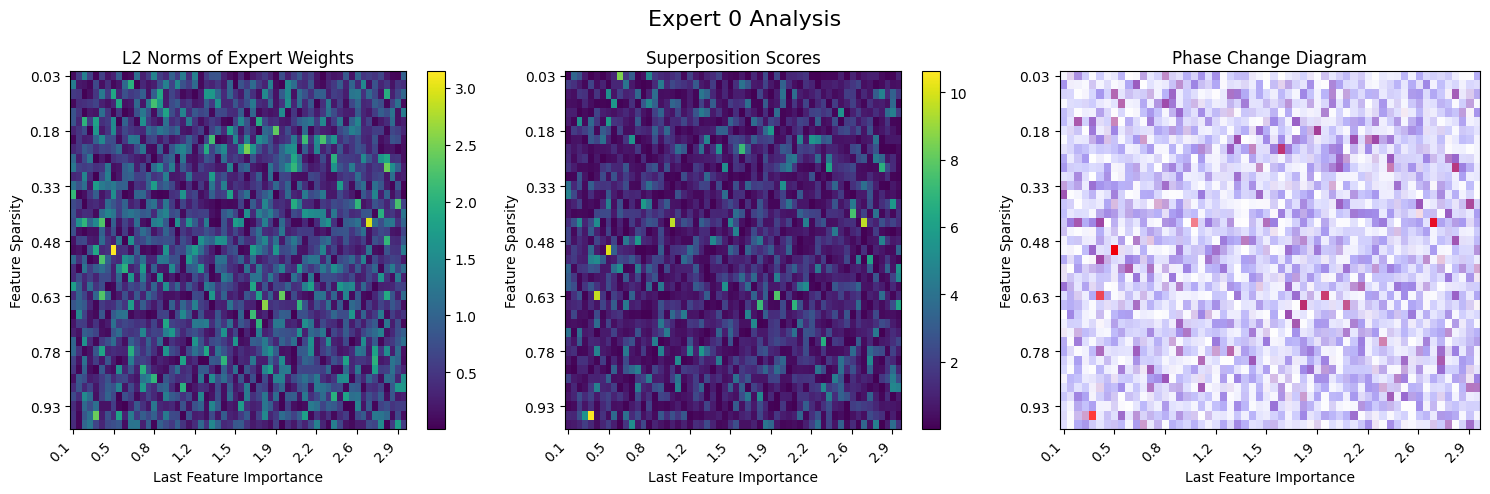

Grid results saved to: phase_change_results/211.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [155]:
run_phase_change(2,1,1, "211")

In [ ]:
run_phase_change(2,1,2, "212")

Creating grid with 4 sparsity values and 29 importance values
Total grid points: 116
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.452905, lr=0.001000
Step 250: avg_loss=0.242860, lr=0.001000


Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.453002, lr=0.001000
Step 2: avg_loss=0.450303, lr=0.001000
Step 4: avg_loss=0.447251, lr=0.001000
Step 6: avg_loss=0.444852, lr=0.001000
Step 8: avg_loss=0.441868, lr=0.001000
Step 9: avg_loss=0.440932, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.568172 (run 1)
  Cell (0.03, 0.2): best loss 0.241930 (run 1)
  Cell (0.03, 0.2): best loss 0.116988 (run 1)
  Cell (0.03, 0.3): best loss 0.168249 (run 1)
  Cell (0.03, 0.3): best loss 0.248490 (run 1)
Training completed in 1.23 seconds
Total models trained: 2262
Analyzing expert allocations for all grid points...
Analyzing 1 experts


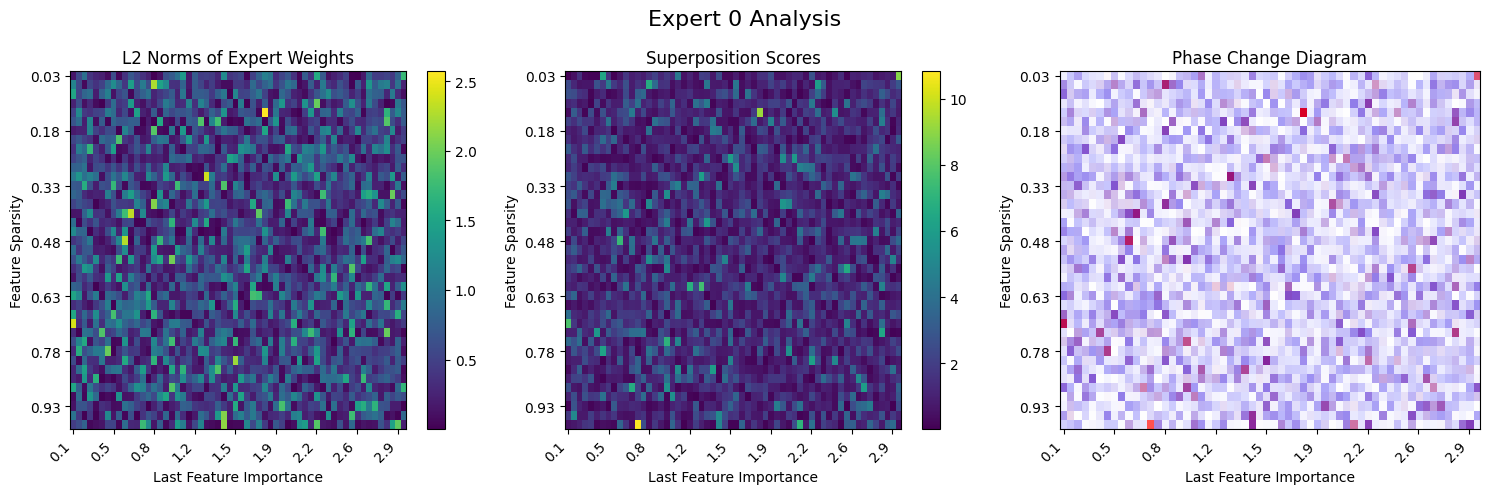

Grid results saved to: phase_change_results/311.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [157]:
run_phase_change(3,1,1, "311")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.355312, lr=0.001000
Step 2: avg_loss=0.353489, lr=0.001000
Step 4: avg_loss=0.351219, lr=0.001000
Step 6: avg_loss=0.349552, lr=0.001000
Step 8: avg_loss=0.346934, lr=0.001000
Step 9: avg_loss=0.346068, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.133615 (run 1)
  Cell (0.03, 0.2): best loss 0.125585 (run 1)
  Cell (0.03, 0.2): best loss 0.255966 (run 1)
  Cell (0.03, 0.3): best loss 0.596772 (run 1)
  Cell (0.03, 0.3): best loss 0.407116 (run 1)
Training completed in 1.65 seconds
Total models trained: 2262
Analyzing expert allocations for all grid points...
Analyzing 2 experts


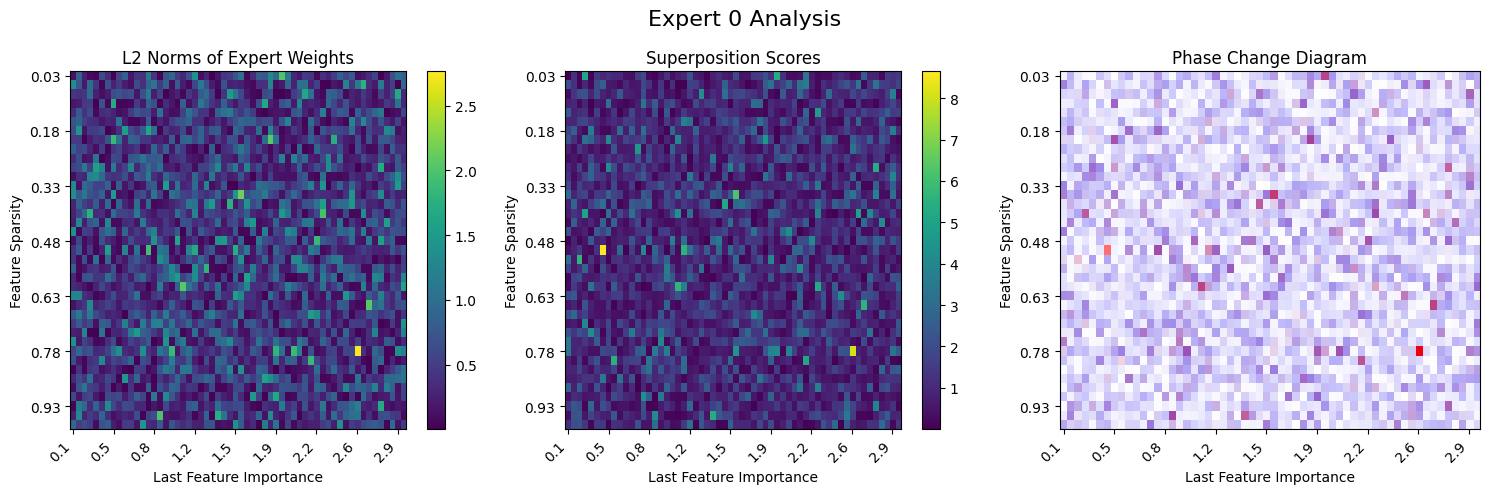

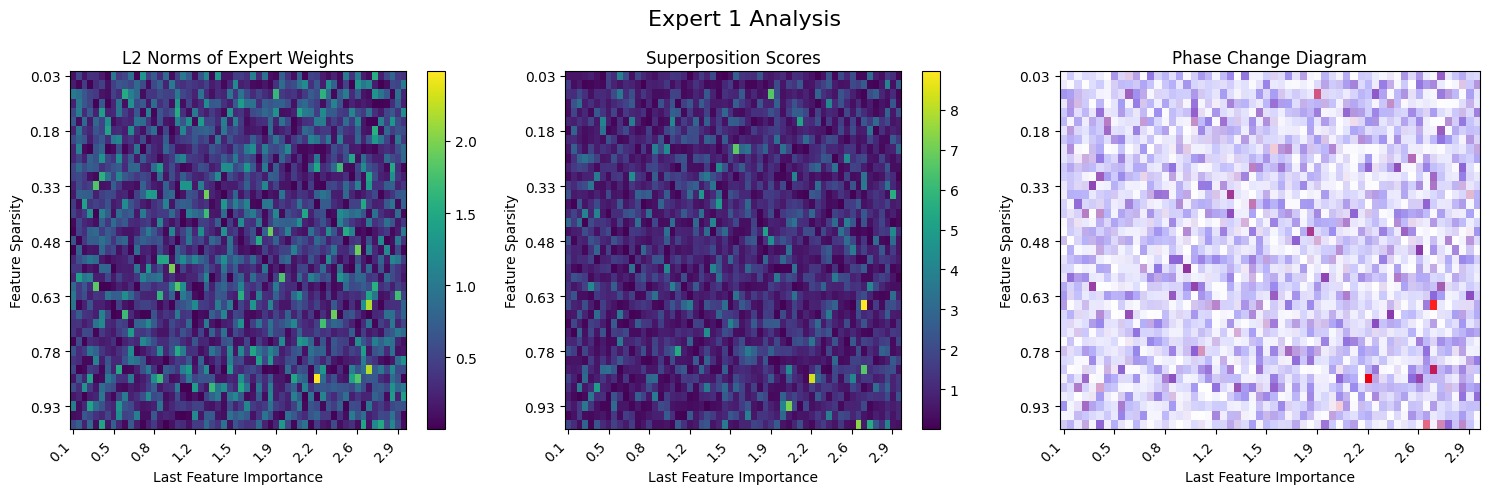

Grid results saved to: phase_change_results/312.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 50 samples per grid cell
Simulating expert activation with 50 samples for 2 experts
Grid size: 39 x 58 = 2262 cells
Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


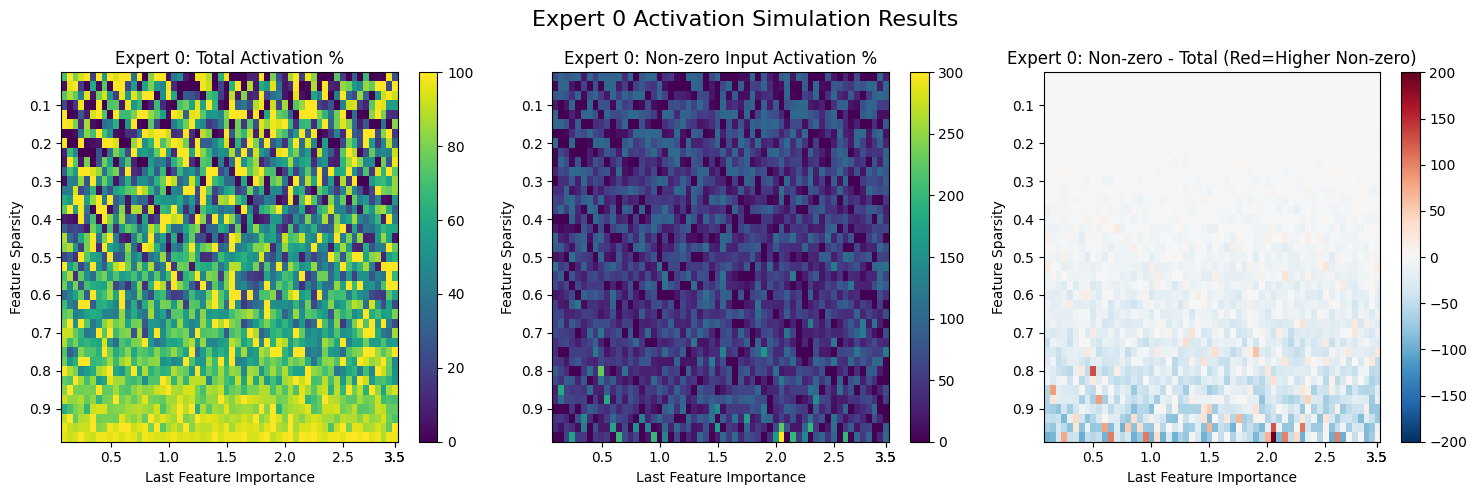


=== Expert 0 Simulation Summary ===
Total activation: 62.00% ± 30.40%
Non-zero input activation: 50.65% ± 36.17%
Difference (Non-zero - Total): -11.35%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


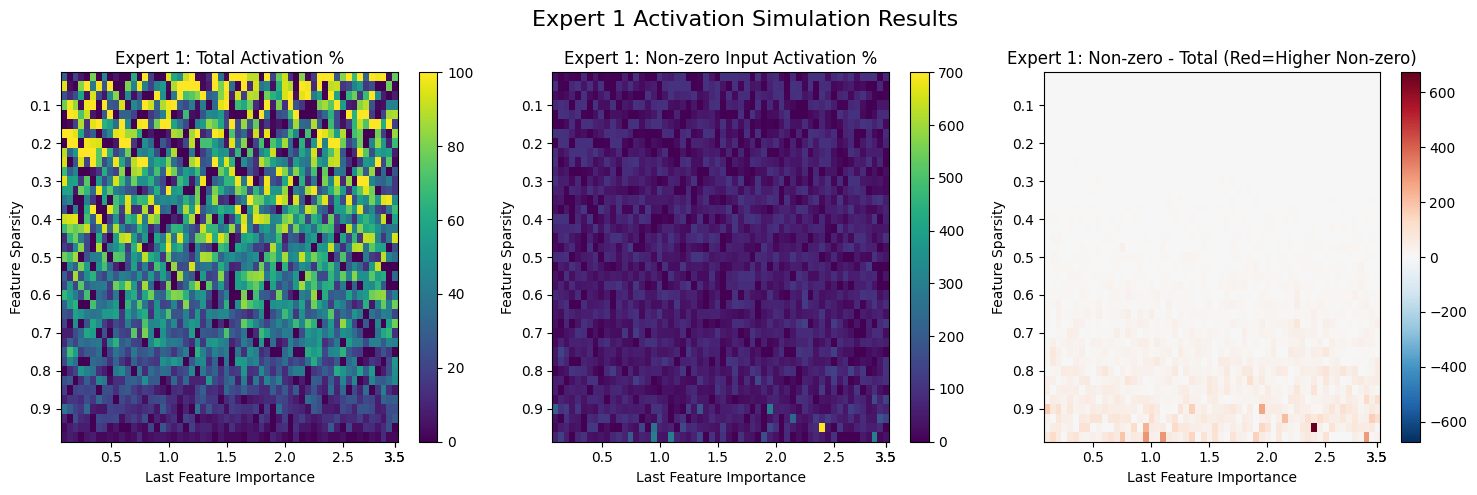


=== Expert 1 Simulation Summary ===
Total activation: 38.00% ± 30.40%
Non-zero input activation: 51.97% ± 39.03%
Difference (Non-zero - Total): 13.96%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 2 experts


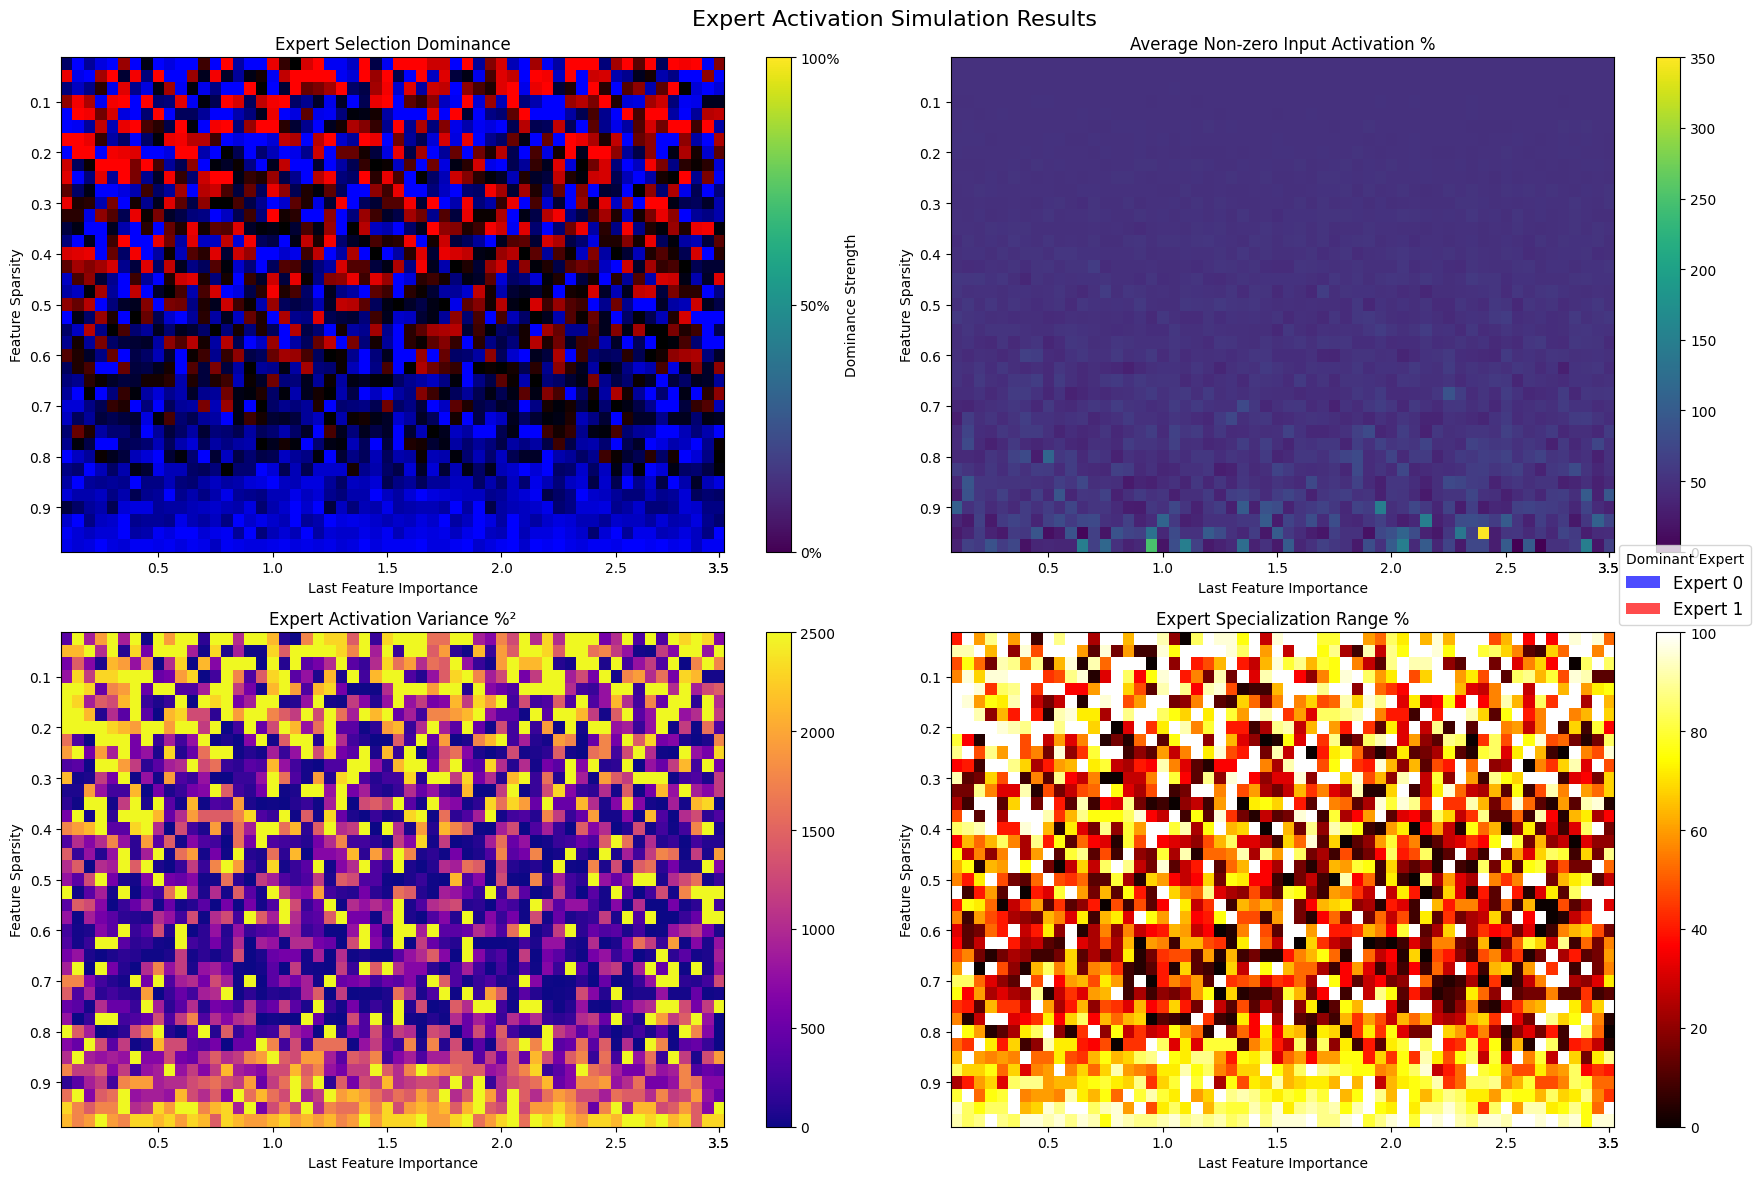


=== Simulation Results Summary ===

Expert 0:
  Total activation: 62.00% ± 30.40%
  Non-zero input activation: 50.65% ± 36.17%
  Difference (Non-zero - Total): -11.35%

Expert 1:
  Total activation: 38.00% ± 30.40%
  Non-zero input activation: 51.97% ± 39.03%
  Difference (Non-zero - Total): 13.96%


In [158]:
run_phase_change(3,1,2, "312")

Creating grid with 39 sparsity values and 58 importance values
Total grid points: 2262
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.303053, lr=0.001000
Step 2: avg_loss=0.301446, lr=0.001000
Step 4: avg_loss=0.299365, lr=0.001000
Step 6: avg_loss=0.297148, lr=0.001000
Step 8: avg_loss=0.295348, lr=0.001000
Step 9: avg_loss=0.294562, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.188622 (run 1)
  Cell (0.03, 0.2): best loss 0.222687 (run 1)
  Cell (0.03, 0.2): best loss 1.100385 (run 1)
  Cell (0.03, 0.3): best loss 0.140522 (run 1)
  Cell (0.03, 0.3): best loss 0.244103 (run 1)
Training completed in 1.86 seconds
Total models trained: 2262
Analyzing expert allocations for all grid points...
Analyzing 3 experts


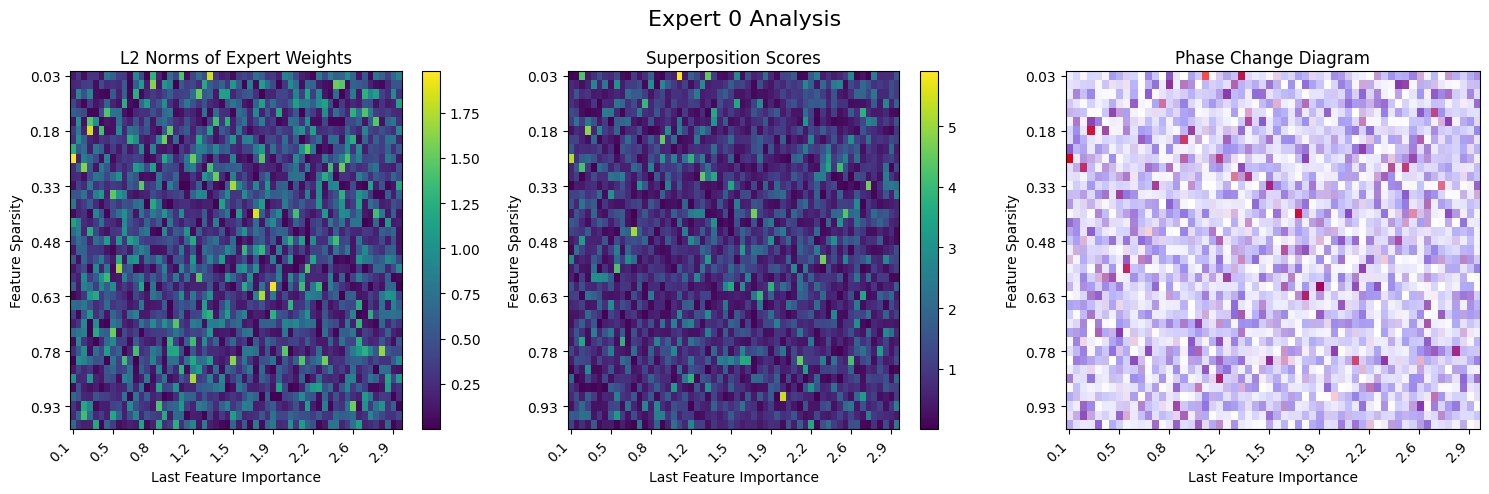

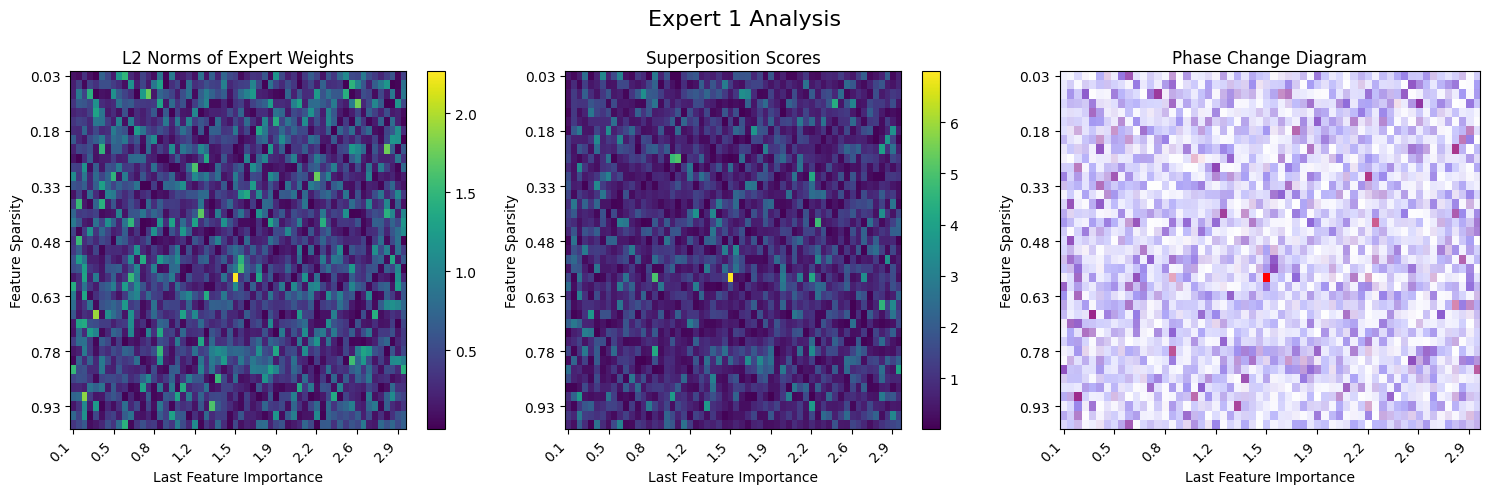

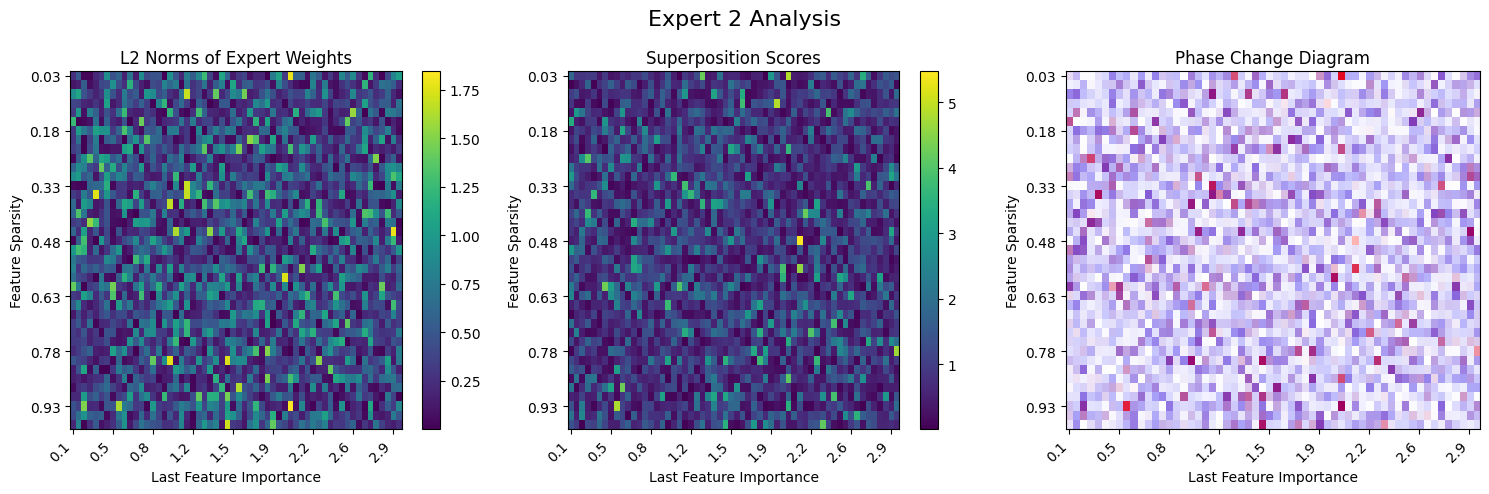

Grid results saved to: phase_change_results/313.npz
Grid size: 39 x 58 = 2262 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata
=== Running Complete Simulation Analysis ===
Simulating 50 samples per grid cell
Simulating expert activation with 50 samples for 3 experts
Grid size: 39 x 58 = 2262 cells
Completed simulation for 2262 grid cells

--- Analyzing Expert 0 ---
Analyzing simulation results for expert 0


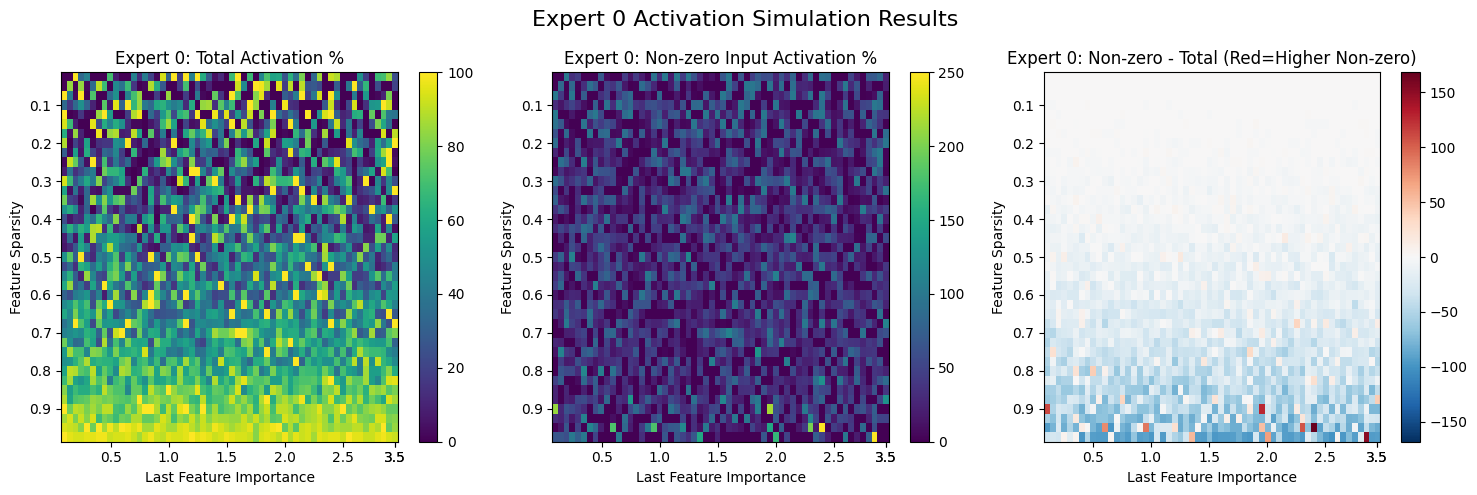


=== Expert 0 Simulation Summary ===
Total activation: 49.94% ± 30.63%
Non-zero input activation: 34.30% ± 32.77%
Difference (Non-zero - Total): -15.64%
  → Expert 0 is activated LESS often for non-zero inputs than overall

--- Analyzing Expert 1 ---
Analyzing simulation results for expert 1


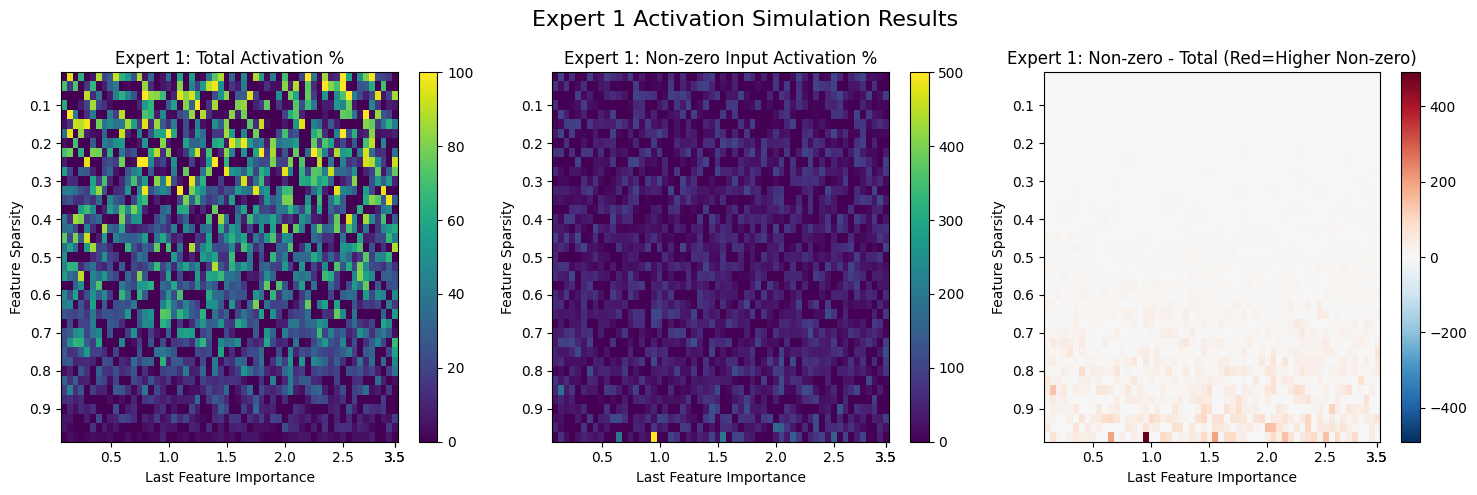


=== Expert 1 Simulation Summary ===
Total activation: 25.07% ± 26.28%
Non-zero input activation: 34.22% ± 33.45%
Difference (Non-zero - Total): 9.15%
  → Expert 1 is activated MORE often for non-zero inputs than overall

--- Analyzing Expert 2 ---
Analyzing simulation results for expert 2


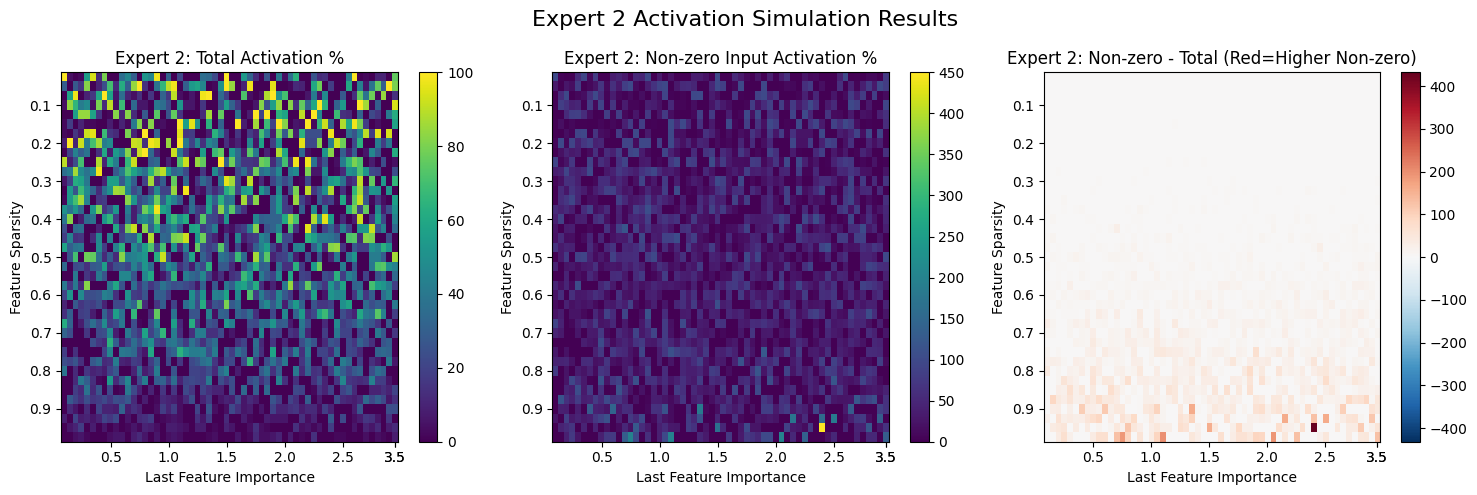


=== Expert 2 Simulation Summary ===
Total activation: 24.99% ± 26.44%
Non-zero input activation: 34.09% ± 33.67%
Difference (Non-zero - Total): 9.10%
  → Expert 2 is activated MORE often for non-zero inputs than overall

--- Overall Analysis ---
Analyzing simulation results for all 3 experts


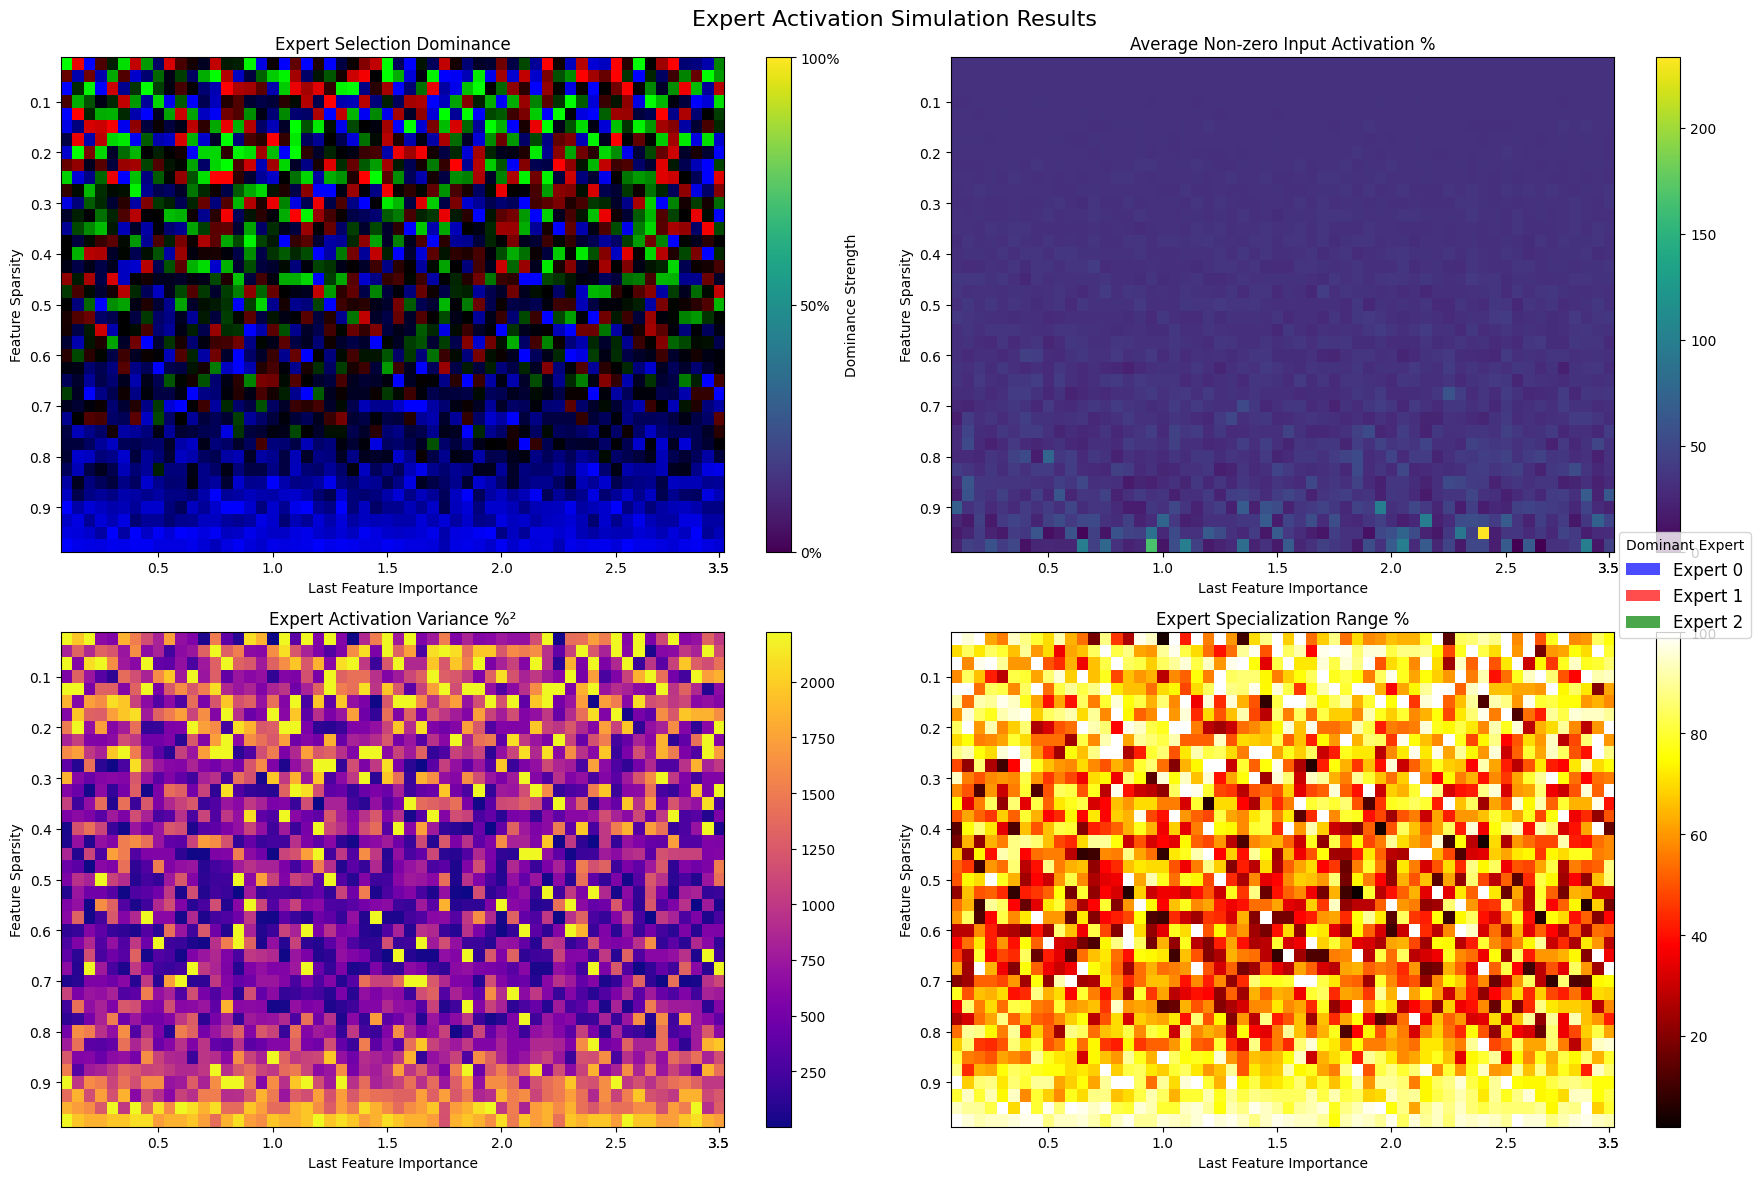


=== Simulation Results Summary ===

Expert 0:
  Total activation: 49.94% ± 30.63%
  Non-zero input activation: 34.30% ± 32.77%
  Difference (Non-zero - Total): -15.64%

Expert 1:
  Total activation: 25.07% ± 26.28%
  Non-zero input activation: 34.22% ± 33.45%
  Difference (Non-zero - Total): 9.15%

Expert 2:
  Total activation: 24.99% ± 26.44%
  Non-zero input activation: 34.09% ± 33.67%
  Difference (Non-zero - Total): 9.10%


In [159]:
run_phase_change(3,1,3, "313")

Creating grid with 39 sparsity values and 78 importance values
Total grid points: 3042
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.433207, lr=0.001000
Step 1: avg_loss=0.431787, lr=0.001000
Step 2: avg_loss=0.430285, lr=0.001000
Step 3: avg_loss=0.429008, lr=0.001000
Step 4: avg_loss=0.427433, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.110475 (run 1)
  Cell (0.03, 0.2): best loss 0.140199 (run 1)
  Cell (0.03, 0.2): best loss 0.179892 (run 1)
  Cell (0.03, 0.3): best loss 0.252485 (run 1)
  Cell (0.03, 0.3): best loss 0.221172 (run 1)
Training completed in 1.28 seconds
Total models trained: 3042
Analyzing expert allocations for all grid points...
Analyzing 1 experts
Processing expert 0
Creating plots for expert 0


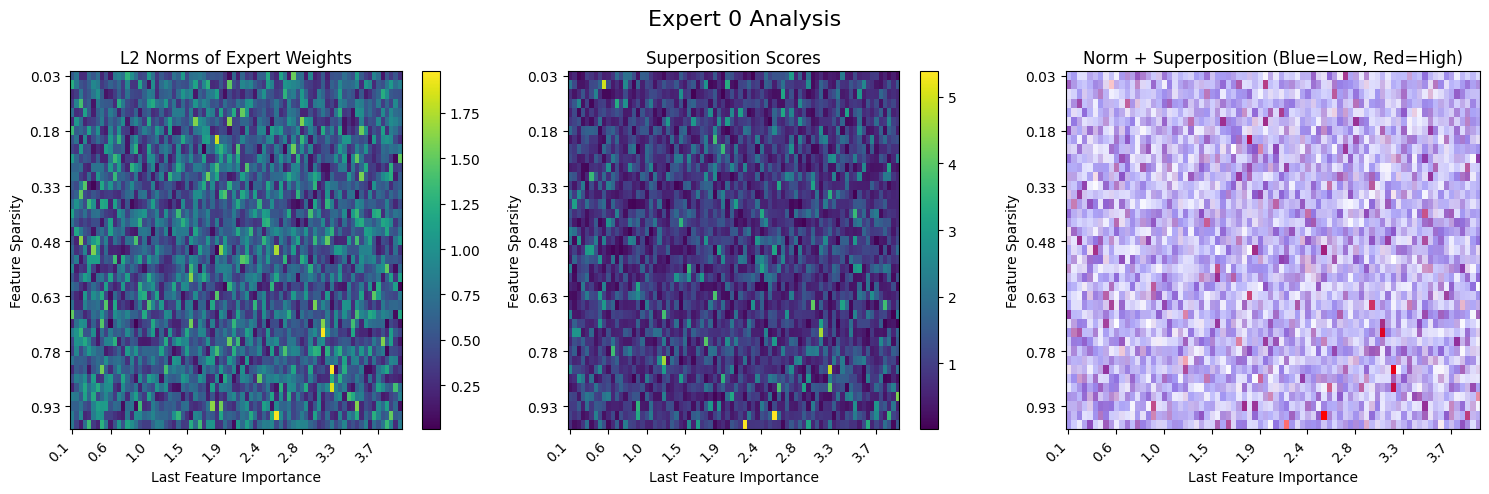

Creating plots for 1 experts
Creating plots for expert 0


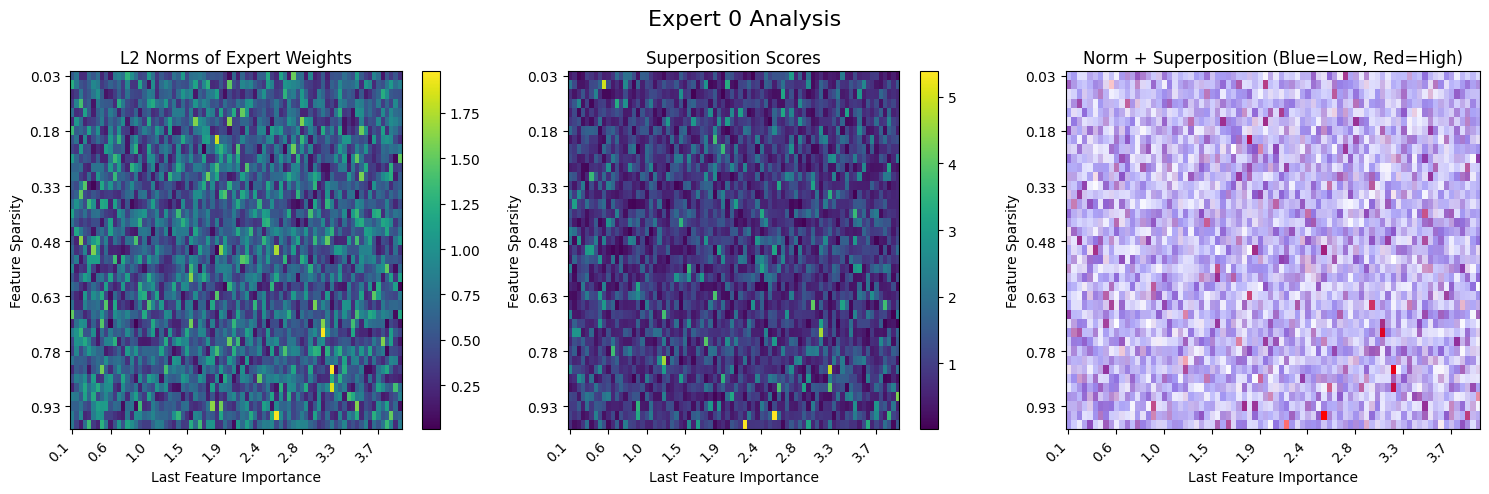

Grid results saved to: 321.npz
Grid size: 39 x 78 = 3042 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [17]:
run_phase_change(3,2,1, "321")

Creating grid with 39 sparsity values and 78 importance values
Total grid points: 3042
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.350268, lr=0.001000
Step 1: avg_loss=0.348710, lr=0.001000
Step 2: avg_loss=0.348194, lr=0.001000
Step 3: avg_loss=0.346965, lr=0.001000
Step 4: avg_loss=0.345826, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.253494 (run 1)
  Cell (0.03, 0.2): best loss 0.233530 (run 1)
  Cell (0.03, 0.2): best loss 0.291732 (run 1)
  Cell (0.03, 0.3): best loss 0.087884 (run 1)
  Cell (0.03, 0.3): best loss 0.249302 (run 1)
Training completed in 1.76 seconds
Total models trained: 3042
Analyzing expert allocations for all grid points...
Analyzing 2 experts
Processing expert 0
Processing expert 1
Creating plots for expert 0


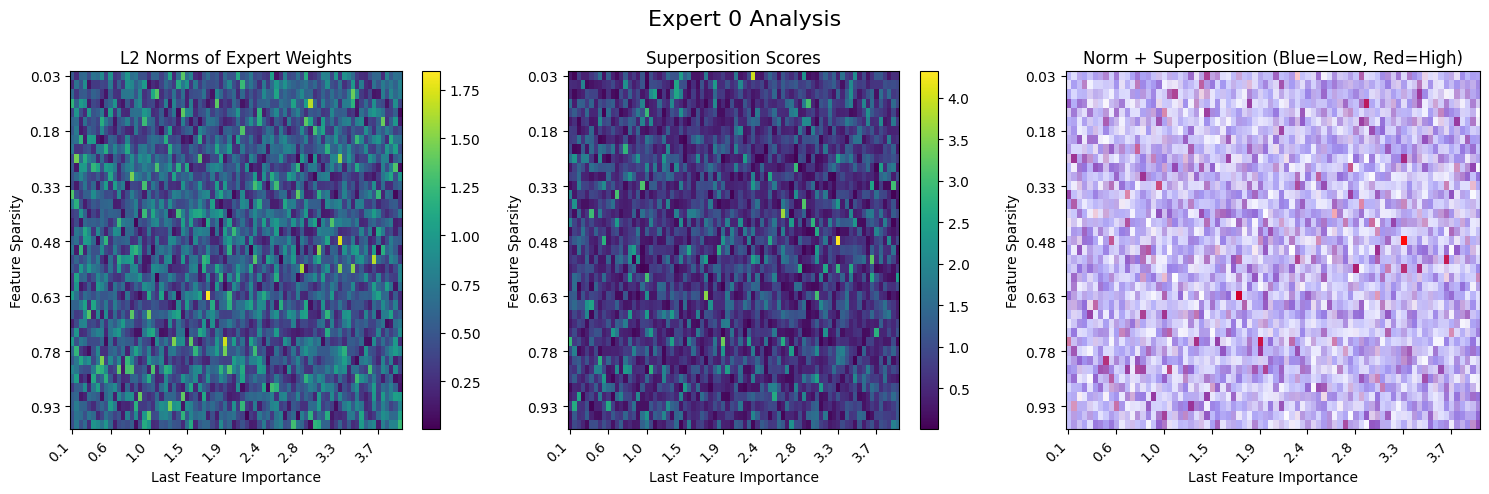

Creating plots for expert 1


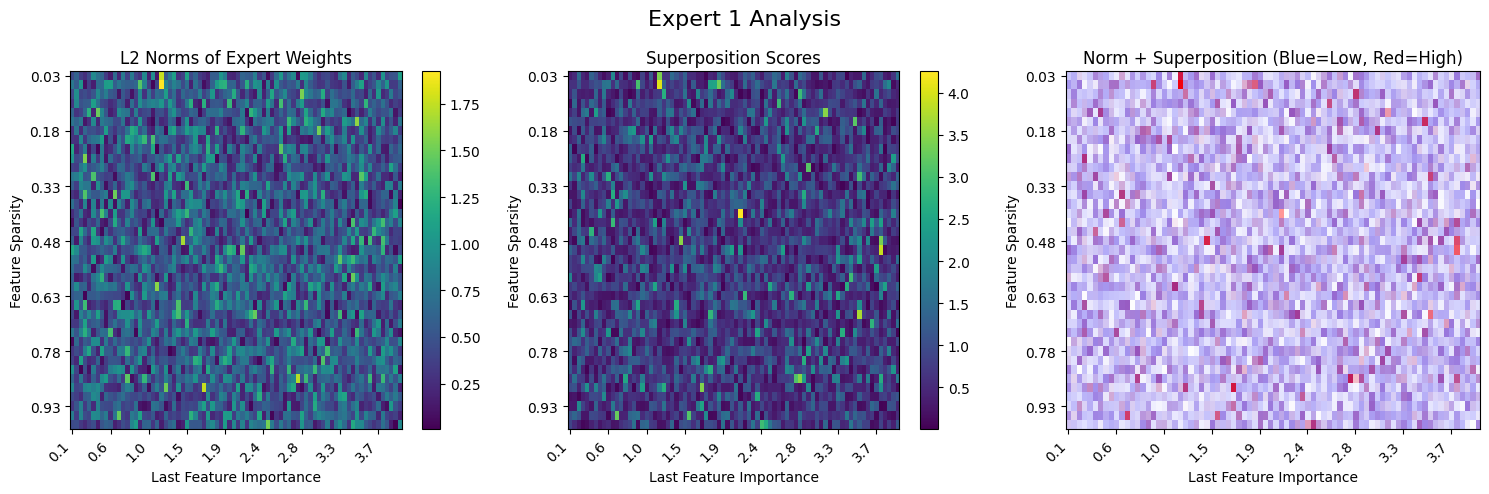

Creating plots for 2 experts
Creating plots for expert 0


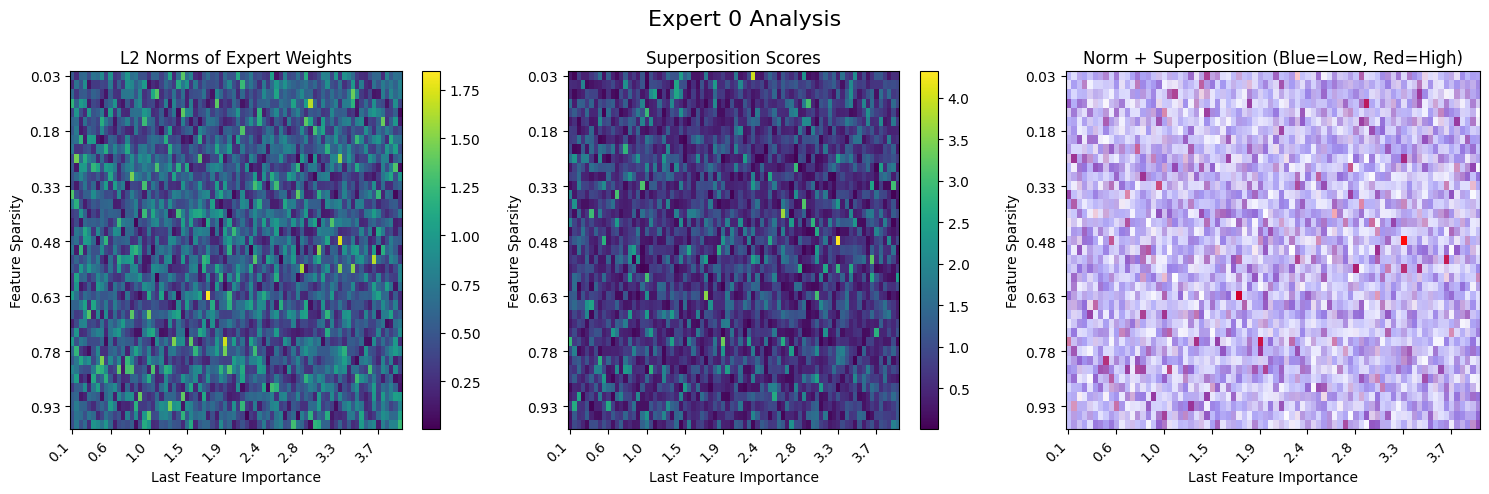

Creating plots for expert 1


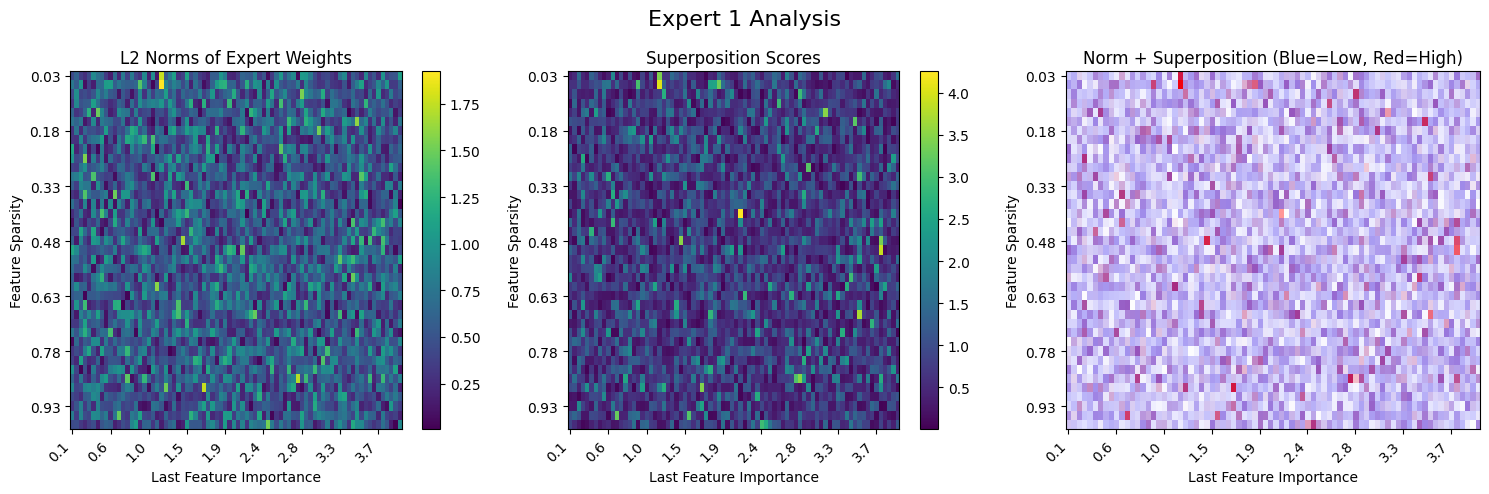

Grid results saved to: 322.npz
Grid size: 39 x 78 = 3042 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [18]:
run_phase_change(3,2,2, "322")

Creating grid with 39 sparsity values and 78 importance values
Total grid points: 3042
Training 1 independent runs...
Training run 1/1...
Step 0: avg_loss=0.305708, lr=0.001000
Step 1: avg_loss=0.305154, lr=0.001000
Step 2: avg_loss=0.303839, lr=0.001000
Step 3: avg_loss=0.302276, lr=0.001000
Step 4: avg_loss=0.301935, lr=0.001000
Selecting best models per grid cell...
  Cell (0.03, 0.1): best loss 0.160160 (run 1)
  Cell (0.03, 0.2): best loss 0.150236 (run 1)
  Cell (0.03, 0.2): best loss 0.156448 (run 1)
  Cell (0.03, 0.3): best loss 0.204601 (run 1)
  Cell (0.03, 0.3): best loss 0.146832 (run 1)
Training completed in 1.56 seconds
Total models trained: 3042
Analyzing expert allocations for all grid points...
Analyzing 3 experts
Processing expert 0
Processing expert 1
Processing expert 2
Creating plots for expert 0


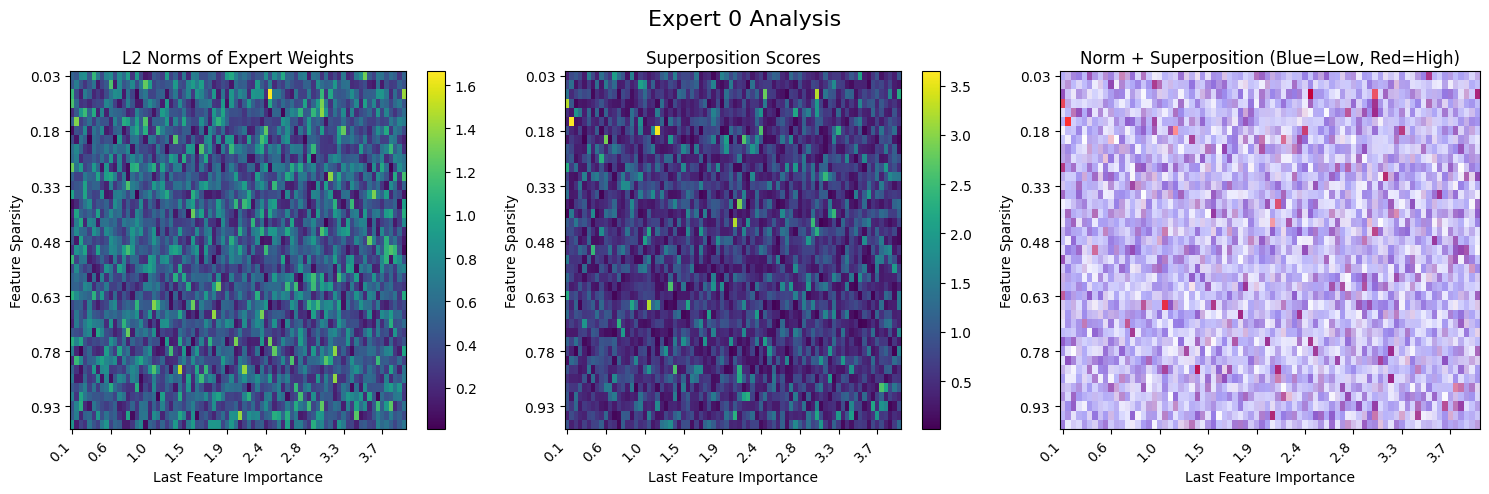

Creating plots for expert 1


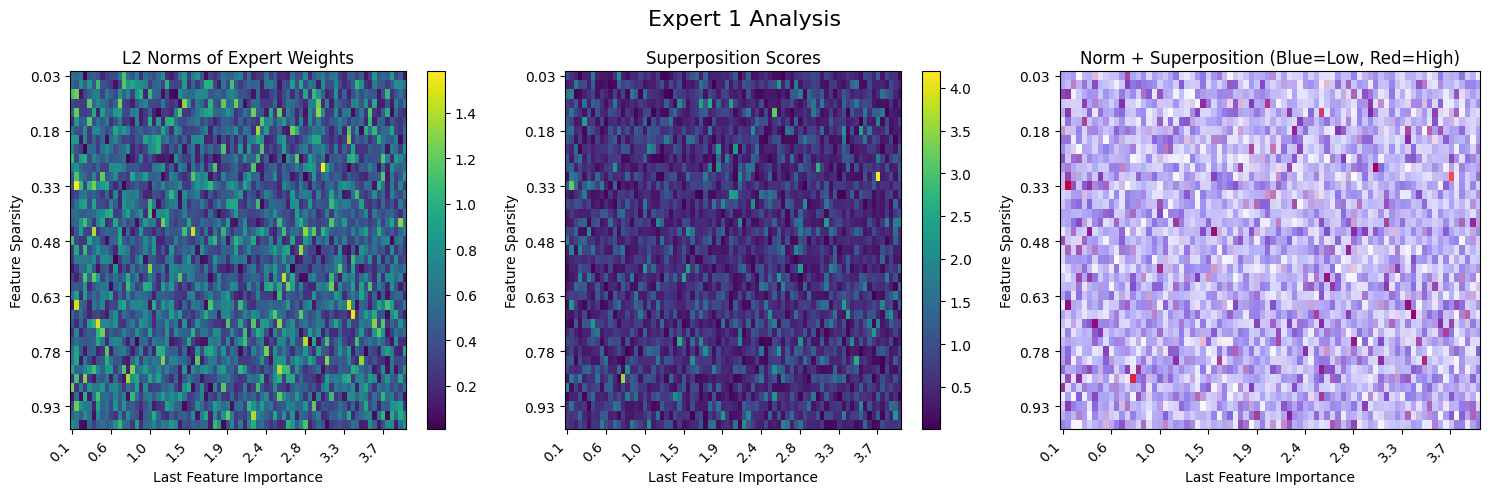

Creating plots for expert 2


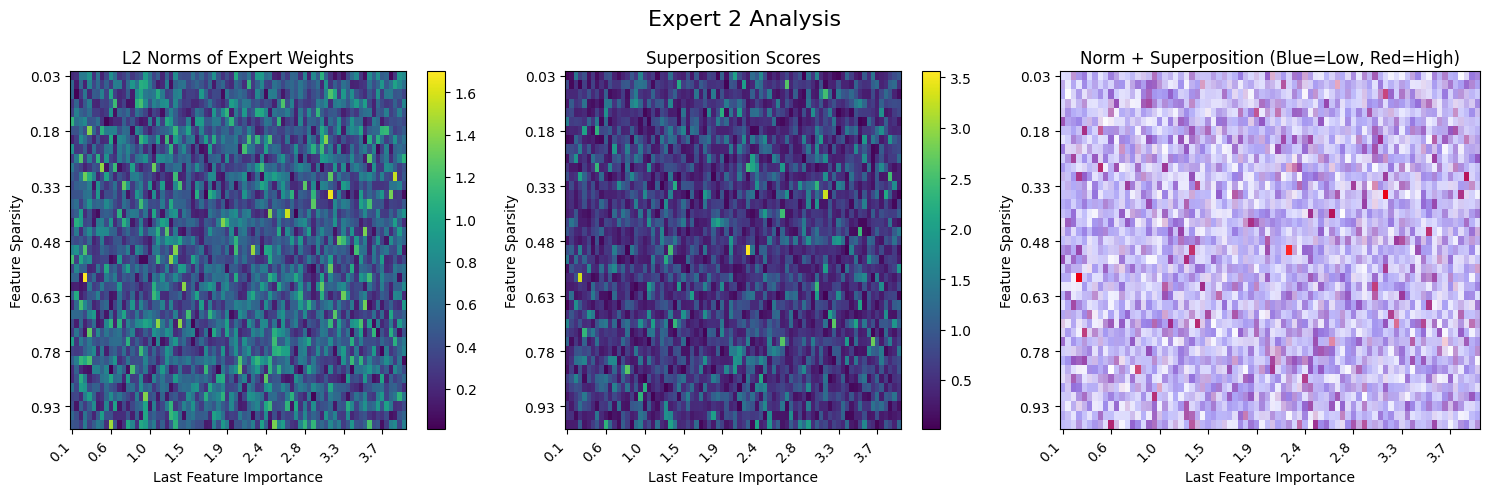

Creating plots for 3 experts
Creating plots for expert 0


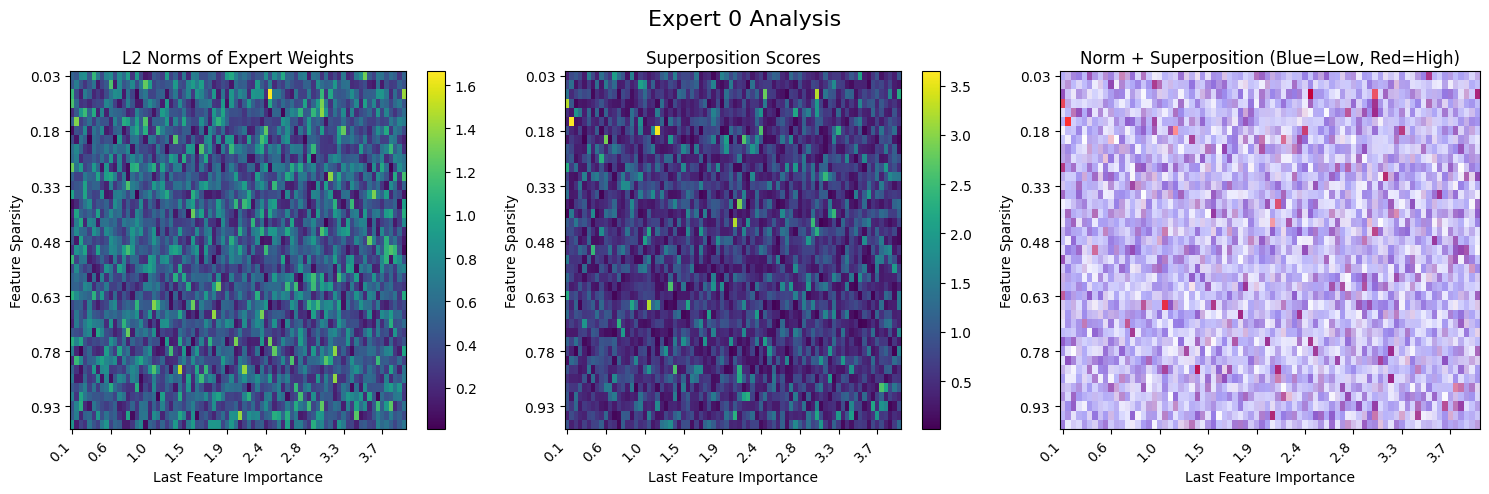

Creating plots for expert 1


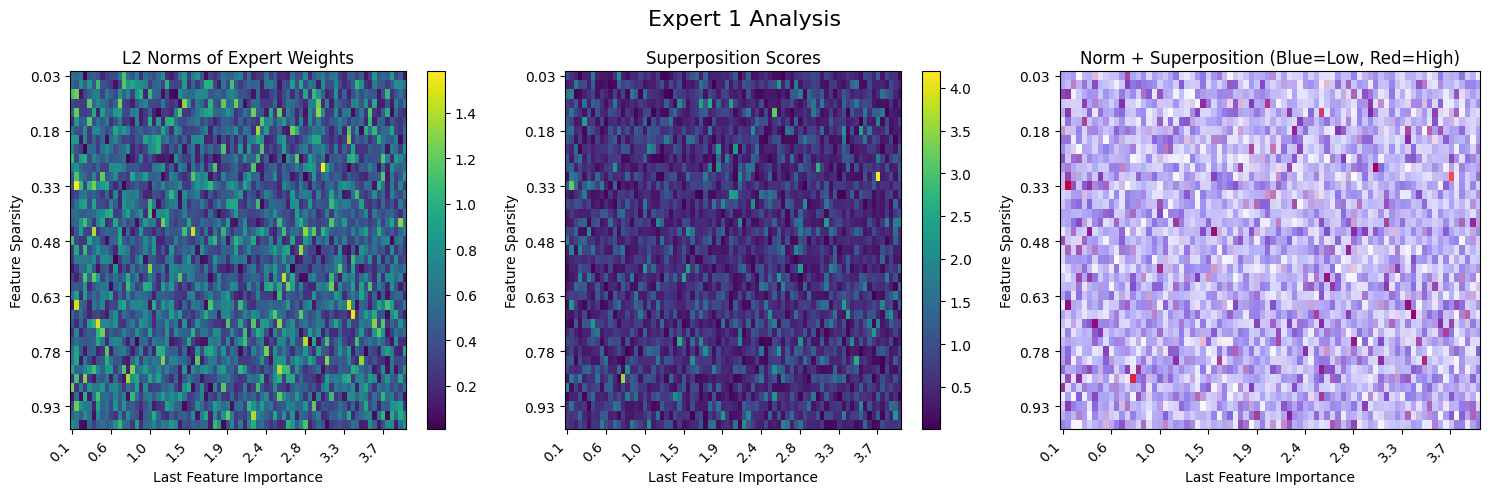

Creating plots for expert 2


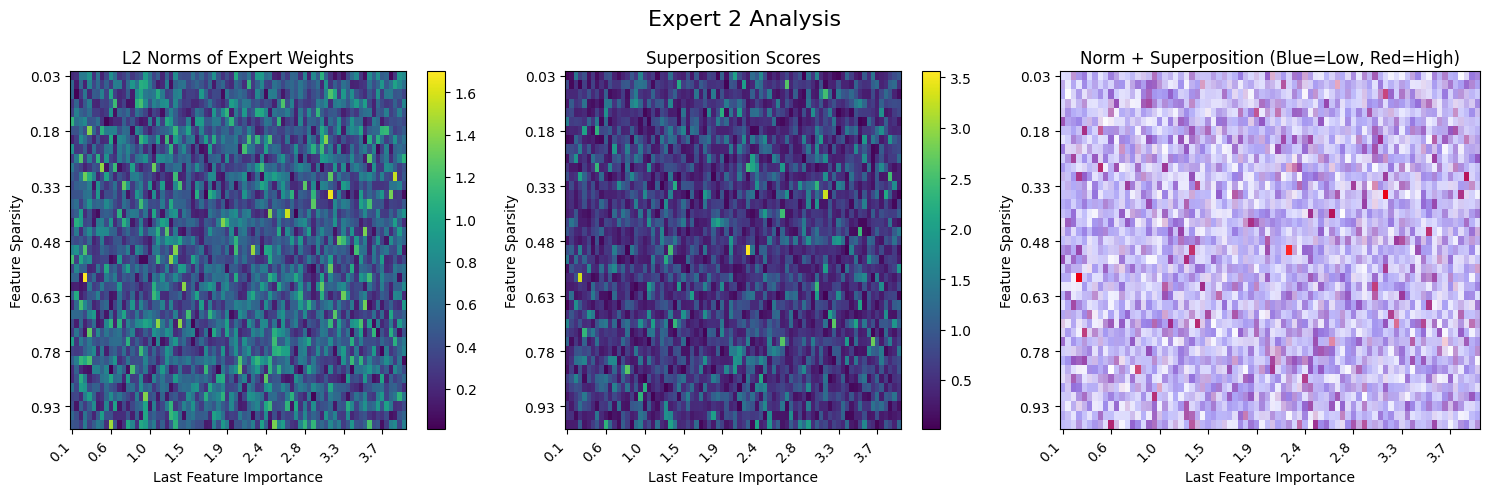

Grid results saved to: 323.npz
Grid size: 39 x 78 = 3042 points
Data includes: grid parameters, losses, expert weights, router weights, config metadata


In [19]:
run_phase_change(3,2,3, "323")